# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=47060667d264c73f5dbba0f038ab3ca6d7df15b874f8926b59fd0cf31f7dd709
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.9 MB/s eta 0:00:00


In [8]:
!pip install shap

In [9]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [74]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-75-0d12c417dce0>:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

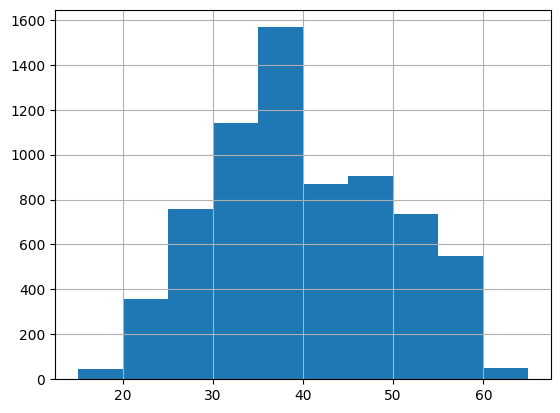

In [75]:
#####################
# "Age"(年齢)の処理 #
#####################
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

    # 数値変換し5足す
    # tmp = int(tmp)
    # all_df.loc[i,"Age"] = tmp + 5
    # all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムの表示
all_df["Age"].hist()

In [76]:
# 年代のラベリングを追加する
# all_df["AgeTeen"] = all_df["Age"]
# all_df["AgeTeen"] = all_df["AgeTeen"] // 10

<Axes: >

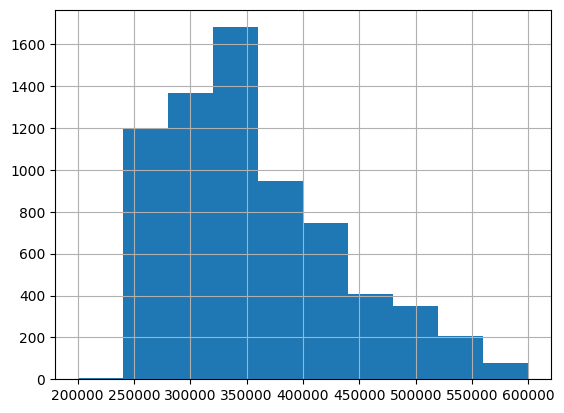

In [77]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

<Axes: >

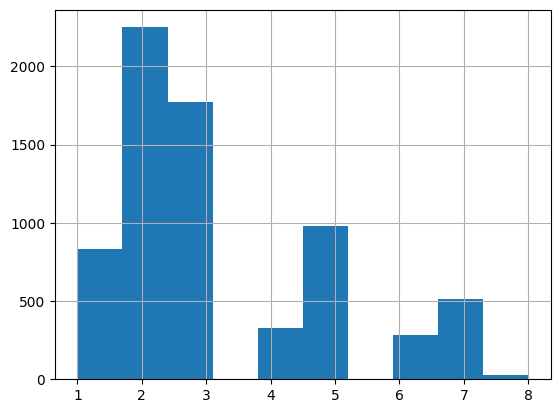

In [78]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [79]:
# 旅行回数を階層化
# all_df["Weight"] = 1
# all_df.loc[all_df["NumberOfTrips"]>=3,"Weight"] = 3
# all_df.loc[all_df["NumberOfTrips"]>=2,"Weight"] = 2

In [80]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [81]:
# 連絡手段の順序
Self = all_df.loc[all_df["TypeofContact"]=="Self Enquiry","NumberOfTrips"].median()
Company = all_df.loc[all_df["TypeofContact"]=="Company Invited","NumberOfTrips"].median()

print(Self)
print(Company)

all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

# 旅行回数で割り当てる
# all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 3
# all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

all_df["TypeofContact"] = all_df["TypeofContact"].astype("int")

all_df["TypeofContact"].value_counts()

3.0
2.0


,count
TypeofContact,
1,4462
2,2516


In [82]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


<Axes: >

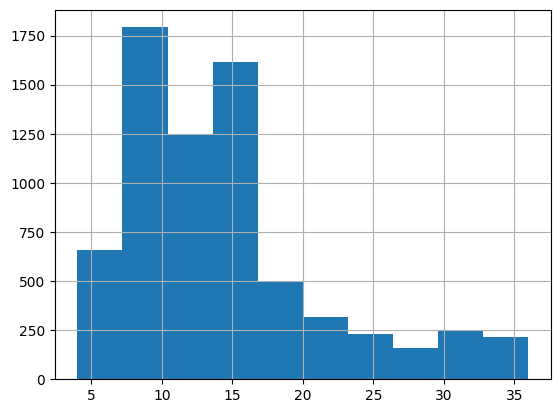

In [83]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 分布の確認
all_df["DurationOfPitch"].hist()

In [84]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [85]:
print(all_df.loc[all_df["Occupation"]=="Small Business","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Salaried","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Large Business","NumberOfTrips"].median())

3.0
3.0
3.0


In [86]:
# 「Occupation」をラベルエンコード(特徴見当たらず)
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
# all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2

In [87]:
# 元の列を削除
all_df = all_df.drop("Occupation", axis=1)

In [88]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

In [89]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [90]:
# ターゲットエンコーディング
# 男性の成約率が女性の1.5倍
print(all_df.loc[all_df["Gender"]=="Female","ProdTaken"].mean())
print(all_df.loc[all_df["Gender"]=="Male","ProdTaken"].mean())

0.13767629281396912
0.17025440313111545


In [91]:
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
# all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
# all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=3
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=1

In [92]:
# 元の列を削除
all_df = all_df.drop("Gender", axis=1)

In [93]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [94]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [95]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [96]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [97]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [98]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [99]:
# 商品ランクの順序
Basic = all_df.loc[all_df["ProductPitched"]=="Basic","MonthlyIncome"].median()
Deluxe = all_df.loc[all_df["ProductPitched"]=="Deluxe","MonthlyIncome"].median()
Standard = all_df.loc[all_df["ProductPitched"]=="Standard","MonthlyIncome"].median()
SuperDeluxe = all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","MonthlyIncome"].median()
King = all_df.loc[all_df["ProductPitched"]=="King","MonthlyIncome"].median()

# Basicを基準とした商品ランクの間隔
base = Deluxe - Basic # これを「2」とする
print(round((Standard - Basic)/base*2))
print(round((SuperDeluxe - Basic)/base*2))
print(round((King - Basic)/base*2))

5
10
11


In [100]:
# 「ProductPitched」をラベルエンコード
# all_df["ProductPitched_LE"] = 1
# all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=10
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=8
# all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=6
# all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=4
# all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=2

all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

In [101]:
# 元の列を削除
all_df = all_df.drop("ProductPitched", axis=1)

In [102]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [103]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

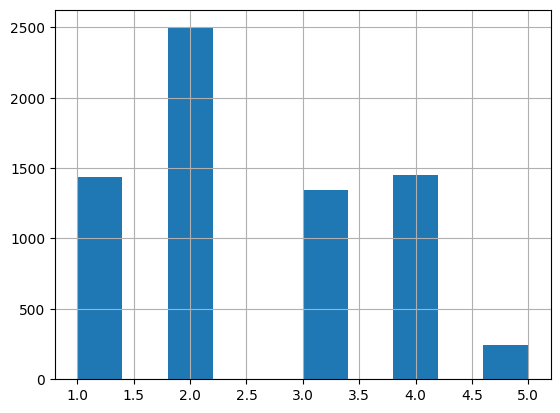

In [104]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [105]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [106]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [107]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [108]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


300000.0
506745.0
474960.0
386752.5
336195.0


<Axes: >

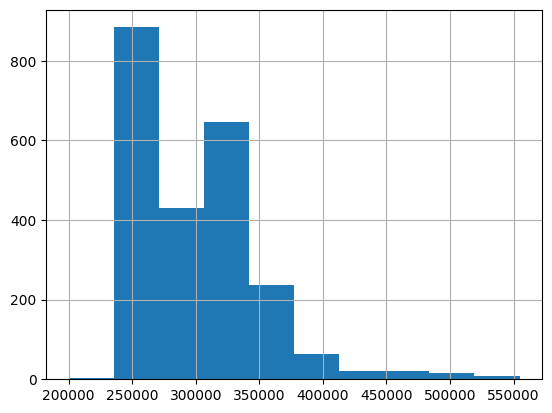

In [109]:
# 最頻値で確認
print(all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median())

all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].hist()

In [110]:
Executive = all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median()
VP = all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median()
AVP = all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median()
Senior = all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median()
Manager = all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median()

print(round((Manager - Executive)/Executive*10))
print(round((Senior - Executive)/Executive*10))
print(round((AVP - Executive)/Executive*10))
print(round((VP - Executive)/Executive*10))

1
3
6
7


In [111]:
# 「Dsignation」をラベルエンコード
# 社長はほとんどが個人事業主のため給料安い。そのため低く見積もる
# all_df["Designation_LE"] = 1
# all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 10
# all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 8
# all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 6
# all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 4
# all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 2

In [112]:
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

In [113]:
# 元の列を削除
all_df = all_df.drop("Designation", axis=1)

In [114]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [115]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [116]:
# 「CarHolder」をラベルエンコード
# all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

In [117]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [118]:
# all_df = all_df.drop("CarHolder", axis=1)

In [119]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [120]:
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

In [121]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


In [122]:
all_df = all_df.drop("Married", axis=1)

# 特徴量エンジニアリング

In [ ]:
# Logを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 削除する
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

In [59]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("NumofChild", axis=1)
# all_df = all_df.drop("Gender_LE", axis=1)
# all_df = all_df.drop("CarHolder", axis=1)
# all_df = all_df.drop("Occupation_LE", axis=1)
# all_df = all_df.drop("NumberOfFollowups", axis=1)
# all_df = all_df.drop("PreferredPropertyStar", axis=1)

In [ ]:
# all_df = all_df.drop("NumberOfFollowups", axis=1)

In [ ]:
# クロス特徴量
# all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [ ]:
all_df.columns

Index(['id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'NumofChild',
       'Designation_LE', 'Occupation_LE', 'CarHolder_LE', 'ProductPitched_LE',
       'Married_LE', 'TypeofContact_LE', 'MonthlyIncomeLOG', 'AgeLOG',
       'Designation_LE_ProductPitched_LE'],
      dtype='object')

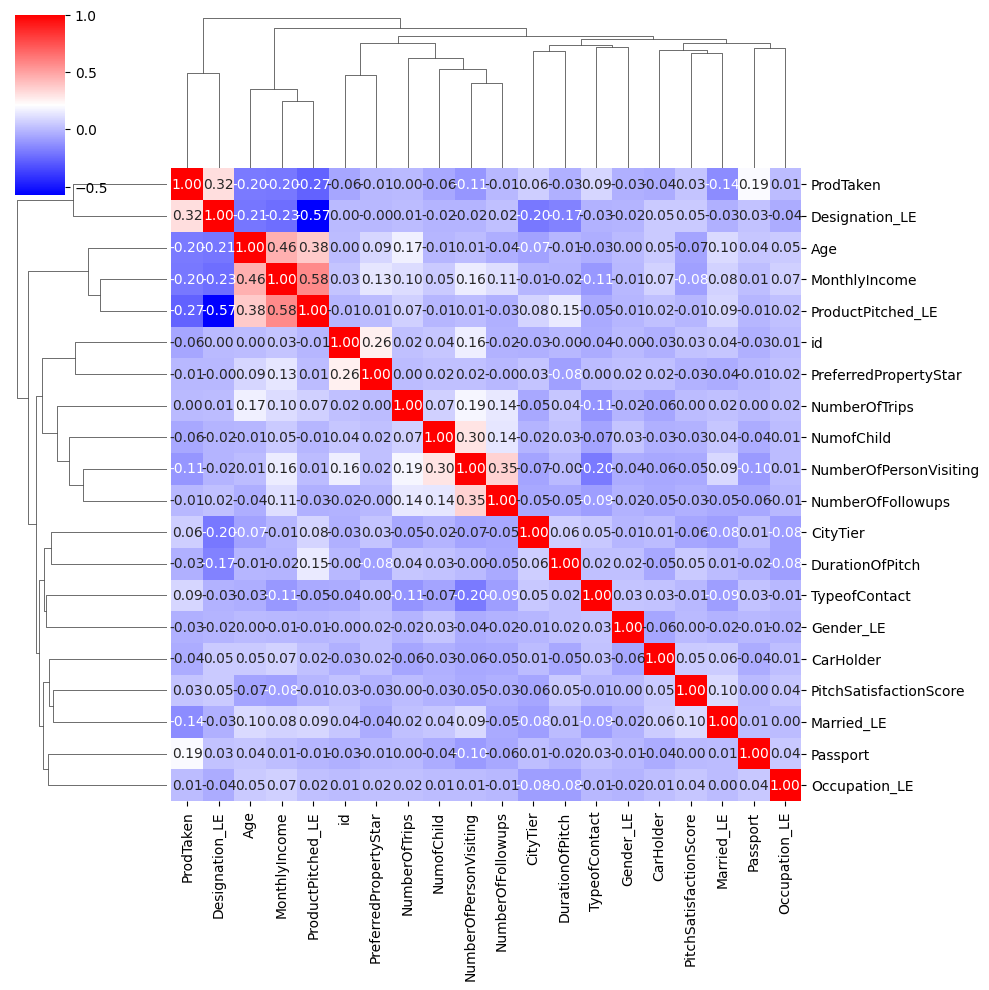

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# ここで一つの区切り

# ここから学習

In [124]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [125]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [126]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [ ]:
# 1つの基準を作る (learning rate = 0.05)
# FOLDS = 5, seed = 42で最適化
# seed は 3 通りとし、42で超えたら評価に値する

In [127]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.05,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-24 03:00:37,212] A new study created in memory with name: no-name-66e8cc26-3cab-4752-b48b-64d79268d0af
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.855136	valid's auc: 0.83587
[200]	train's auc: 0.864695	valid's auc: 0.838094
#########################
### Fold 2
#########################
[100]	train's auc: 0.852603	valid's auc: 0.839649
[200]	train's auc: 0.861255	valid's auc: 0.844448
#########################
### Fold 3
#########################
[100]	train's auc: 0.860273	valid's auc: 0.806951
[200]	train's auc: 0.869526	valid's auc: 0.811184
[300]	train's auc: 0.873523	valid's auc: 0.812448
[400]	train's auc: 0.875063	valid's auc: 0.812583
[500]	train's auc: 0.875443	valid's auc: 0.813696
#########################
### Fold 4
#########################
[100]	train's auc: 0.854098	valid's auc: 0.829952
#########################
### Fold 5
#########################
[100]	train's auc: 0.858035	valid's auc: 0.811341
[200]	train's auc: 0.867495	valid's auc: 0.812895


[I 2025-05-24 03:00:38,753] Trial 0 finished with value: 0.8151495873637548 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 45, 'feature_fraction': 0.5707635950626984, 'bagging_fraction': 0.740994859340603, 'bagging_freq': 7, 'lambda_l1': 8.984145770193573, 'lambda_l2': 4.113484007128907e-08, 'max_depth': 8}. Best is trial 0 with value: 0.8151495873637548.


[300]	train's auc: 0.87034	valid's auc: 0.813351
[400]	train's auc: 0.872619	valid's auc: 0.812946
#########################
### Fold 1
#########################
[100]	train's auc: 0.866478	valid's auc: 0.832742


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.866625	valid's auc: 0.845084
[200]	train's auc: 0.887383	valid's auc: 0.842458
#########################
### Fold 3
#########################
[100]	train's auc: 0.870534	valid's auc: 0.808098
[200]	train's auc: 0.889383	valid's auc: 0.814354
[300]	train's auc: 0.901974	valid's auc: 0.815281
#########################
### Fold 4
#########################
[100]	train's auc: 0.867094	valid's auc: 0.833375
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:39,738] Trial 1 finished with value: 0.8274920243385446 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 66, 'feature_fraction': 0.5186516146532739, 'bagging_fraction': 0.7231729964811643, 'bagging_freq': 5, 'lambda_l1': 0.7859858617879202, 'lambda_l2': 9.039986056531773e-08, 'max_depth': 3}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.872258	valid's auc: 0.816932
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.944987	valid's auc: 0.81908
#########################
### Fold 2
#########################
[100]	train's auc: 0.944033	valid's auc: 0.838428
#########################
### Fold 3
#########################
[100]	train's auc: 0.946014	valid's auc: 0.807086
[200]	train's auc: 0.980737	valid's auc: 0.806192
#########################
### Fold 4
#########################
[100]	train's auc: 0.941718	valid's auc: 0.821875


[I 2025-05-24 03:00:42,552] Trial 2 finished with value: 0.8068706355781751 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 66, 'feature_fraction': 0.6594952574285017, 'bagging_fraction': 0.8940426692360646, 'bagging_freq': 1, 'lambda_l1': 0.17064240458648755, 'lambda_l2': 1.133896462785341e-06, 'max_depth': 10}. Best is trial 1 with value: 0.8274920243385446.


#########################
### Fold 5
#########################
[100]	train's auc: 0.948644	valid's auc: 0.799551
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.888237	valid's auc: 0.825452
#########################
### Fold 2
#########################
[100]	train's auc: 0.885774	valid's auc: 0.840167
#########################
### Fold 3
#########################
[100]	train's auc: 0.886912	valid's auc: 0.808233
[200]	train's auc: 0.917875	valid's auc: 0.808907
#########################
### Fold 4
#########################
[100]	train's auc: 0.887672	valid's auc: 0.825349
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:43,699] Trial 3 finished with value: 0.8238259772538977 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 87, 'feature_fraction': 0.8771912935046631, 'bagging_fraction': 0.7165666649759408, 'bagging_freq': 5, 'lambda_l1': 1.6696251945932876, 'lambda_l2': 2.056937180994575, 'max_depth': 7}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.889987	valid's auc: 0.811104
[200]	train's auc: 0.919331	valid's auc: 0.808858
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.881226	valid's auc: 0.83214
[200]	train's auc: 0.910454	valid's auc: 0.828579
#########################
### Fold 2
#########################
[100]	train's auc: 0.878838	valid's auc: 0.840351
#########################
### Fold 3
#########################
[100]	train's auc: 0.883213	valid's auc: 0.805062
#########################
### Fold 4
#########################


[I 2025-05-24 03:00:44,523] Trial 4 finished with value: 0.8186892074371361 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 11, 'feature_fraction': 0.5586407113256708, 'bagging_fraction': 0.9442768606703509, 'bagging_freq': 6, 'lambda_l1': 0.000344004309205324, 'lambda_l2': 1.2378056485069137e-08, 'max_depth': 3}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.880538	valid's auc: 0.831849
#########################
### Fold 5
#########################
[100]	train's auc: 0.885073	valid's auc: 0.822151
[200]	train's auc: 0.91612	valid's auc: 0.819212
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.930875	valid's auc: 0.828043
#########################
### Fold 2
#########################
[100]	train's auc: 0.925908	valid's auc: 0.833896
#########################
### Fold 3
#########################
[100]	train's auc: 0.935532	valid's auc: 0.799953
[200]	train's auc: 0.968935	valid's auc: 0.80169
#########################
### Fold 4
#########################
[100]	train's auc: 0.936744	valid's auc: 0.828755
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:45,613] Trial 5 finished with value: 0.8167749814394387 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 17, 'feature_fraction': 0.7436338795702531, 'bagging_fraction': 0.602350142523254, 'bagging_freq': 7, 'lambda_l1': 0.0019603045987717717, 'lambda_l2': 0.04077651486617938, 'max_depth': 5}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.942121	valid's auc: 0.795362
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.964568	valid's auc: 0.814699
#########################
### Fold 2
#########################
[100]	train's auc: 0.957738	valid's auc: 0.83286
#########################
### Fold 3
#########################
[100]	train's auc: 0.960762	valid's auc: 0.800914
#########################
### Fold 4
#########################
[100]	train's auc: 0.964341	valid's auc: 0.819851
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:47,014] Trial 6 finished with value: 0.8030203278494497 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 38, 'feature_fraction': 0.805978483599554, 'bagging_fraction': 0.6904636653837792, 'bagging_freq': 6, 'lambda_l1': 6.8881033116400825e-06, 'lambda_l2': 0.0010781423830278625, 'max_depth': 9}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.968115	valid's auc: 0.78418
#########################
### Fold 1
#########################
[100]	train's auc: 0.89972	valid's auc: 0.827993


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89638	valid's auc: 0.834849
#########################
### Fold 3
#########################
[100]	train's auc: 0.899627	valid's auc: 0.809042
#########################
### Fold 4
#########################
[100]	train's auc: 0.900788	valid's auc: 0.827726


[I 2025-05-24 03:00:47,973] Trial 7 finished with value: 0.8273107898729274 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 83, 'feature_fraction': 0.8941330087733614, 'bagging_fraction': 0.5582883037347625, 'bagging_freq': 5, 'lambda_l1': 0.0008460086587297476, 'lambda_l2': 1.473747988011109e-06, 'max_depth': 7}. Best is trial 1 with value: 0.8274920243385446.


#########################
### Fold 5
#########################
[100]	train's auc: 0.903635	valid's auc: 0.813908
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.90745	valid's auc: 0.829766
#########################
### Fold 2
#########################
[100]	train's auc: 0.903138	valid's auc: 0.843361
#########################
### Fold 3
#########################
[100]	train's auc: 0.90515	valid's auc: 0.807862
[200]	train's auc: 0.942276	valid's auc: 0.805029
#########################
### Fold 4
#########################
[100]	train's auc: 0.906791	valid's auc: 0.830677
#########################
### Fold 5
#########################
[100]	train's auc: 0.908281	valid's auc: 0.811527


[I 2025-05-24 03:00:49,162] Trial 8 finished with value: 0.8233162343042211 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 92, 'feature_fraction': 0.5331962453549594, 'bagging_fraction': 0.7056480029165552, 'bagging_freq': 3, 'lambda_l1': 0.016509980369126098, 'lambda_l2': 0.0028635160788034486, 'max_depth': 11}. Best is trial 1 with value: 0.8274920243385446.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.847834	valid's auc: 0.835209
#########################
### Fold 2
#########################
[100]	train's auc: 0.845226	valid's auc: 0.840995
[200]	train's auc: 0.852911	valid's auc: 0.845669
[300]	train's auc: 0.857361	valid's auc: 0.84587
#########################
### Fold 3
#########################
[100]	train's auc: 0.853693	valid's auc: 0.804868
[200]	train's auc: 0.862079	valid's auc: 0.807339
[300]	train's auc: 0.865189	valid's auc: 0.809649
[400]	train's auc: 0.866595	valid's auc: 0.810408
#########################
### Fold 4
#########################
[100]	train's auc: 0.848859	valid's auc: 0.823772
[200]	train's auc: 0.856951	valid's auc: 0.826276
[300]	train's auc: 0.860987	valid's auc: 0.828688
[400]	train's auc: 0.863751	valid's auc: 0.829649
[500]	train's auc: 0.865395	valid's auc: 0.830188
[600]	train's auc: 0.86699	valid's auc: 0.829767
#########################
### Fold 5
#############

[I 2025-05-24 03:00:50,832] Trial 9 finished with value: 0.8273958591118906 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 67, 'feature_fraction': 0.636881137613351, 'bagging_fraction': 0.8953748041174988, 'bagging_freq': 3, 'lambda_l1': 9.561033005391527, 'lambda_l2': 8.756938464351173, 'max_depth': 3}. Best is trial 1 with value: 0.8274920243385446.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914673	valid's auc: 0.827375
#########################
### Fold 2
#########################
[100]	train's auc: 0.91129	valid's auc: 0.837391
#########################
### Fold 3
#########################
[100]	train's auc: 0.917511	valid's auc: 0.805619
#########################
### Fold 4
#########################
[100]	train's auc: 0.915524	valid's auc: 0.826377
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:51,858] Trial 10 finished with value: 0.8139377710110932 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 63, 'feature_fraction': 0.9742950605541559, 'bagging_fraction': 0.8153111040353015, 'bagging_freq': 1, 'lambda_l1': 2.383514984516171e-08, 'lambda_l2': 6.847548504705785e-06, 'max_depth': 5}. Best is trial 1 with value: 0.8274920243385446.


[100]	train's auc: 0.917505	valid's auc: 0.807861
#########################
### Fold 1
#########################
[100]	train's auc: 0.865621	valid's auc: 0.833813


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.88708	valid's auc: 0.831823
#########################
### Fold 2
#########################
[100]	train's auc: 0.862212	valid's auc: 0.845602
#########################
### Fold 3
#########################
[100]	train's auc: 0.869768	valid's auc: 0.805872
[200]	train's auc: 0.889674	valid's auc: 0.811015
#########################
### Fold 4
#########################
[100]	train's auc: 0.867922	valid's auc: 0.835753
[200]	train's auc: 0.889649	valid's auc: 0.830205
#########################
### Fold 5
#########################
[100]	train's auc: 0.871368	valid's auc: 0.815733


[I 2025-05-24 03:00:54,619] Trial 11 finished with value: 0.8283901268574012 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 72, 'feature_fraction': 0.653240906553299, 'bagging_fraction': 0.8575569429908381, 'bagging_freq': 3, 'lambda_l1': 0.2516792890706442, 'lambda_l2': 1.9956466931105126, 'max_depth': 3}. Best is trial 11 with value: 0.8283901268574012.


[200]	train's auc: 0.892845	valid's auc: 0.813554
#########################
### Fold 1
#########################
[100]	train's auc: 0.902263	valid's auc: 0.834064


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89875	valid's auc: 0.842742
#########################
### Fold 3
#########################
[100]	train's auc: 0.904756	valid's auc: 0.807946
[200]	train's auc: 0.937211	valid's auc: 0.803831
#########################
### Fold 4
#########################
[100]	train's auc: 0.899953	valid's auc: 0.831639
#########################
### Fold 5
#########################


[I 2025-05-24 03:00:55,719] Trial 12 finished with value: 0.8266578078094234 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 76, 'feature_fraction': 0.6684407767277041, 'bagging_fraction': 0.8227973358690368, 'bagging_freq': 3, 'lambda_l1': 0.17332750523671042, 'lambda_l2': 3.653705769580476e-05, 'max_depth': 5}. Best is trial 11 with value: 0.8283901268574012.


[100]	train's auc: 0.906804	valid's auc: 0.808537
#########################
### Fold 1
#########################
[100]	train's auc: 0.872715	valid's auc: 0.833462


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.870409	valid's auc: 0.849532
#########################
### Fold 3
#########################
[100]	train's auc: 0.876873	valid's auc: 0.805214
[200]	train's auc: 0.898392	valid's auc: 0.811639
#########################
### Fold 4
#########################
[100]	train's auc: 0.874823	valid's auc: 0.83378
[200]	train's auc: 0.897664	valid's auc: 0.829885
#########################
### Fold 5
#########################
[100]	train's auc: 0.875618	valid's auc: 0.815395


[I 2025-05-24 03:00:56,783] Trial 13 finished with value: 0.8269933773765588 and parameters: {'num_leaves': 251, 'min_data_in_leaf': 51, 'feature_fraction': 0.521127992525494, 'bagging_fraction': 0.831135468712456, 'bagging_freq': 4, 'lambda_l1': 2.7927951252391553e-06, 'lambda_l2': 0.12362700008594746, 'max_depth': 3}. Best is trial 11 with value: 0.8283901268574012.


[200]	train's auc: 0.901096	valid's auc: 0.815935
[300]	train's auc: 0.91586	valid's auc: 0.812489
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.920825	valid's auc: 0.832809
#########################
### Fold 2
#########################
[100]	train's auc: 0.916507	valid's auc: 0.839833
#########################
### Fold 3
#########################
[100]	train's auc: 0.918601	valid's auc: 0.805905
[200]	train's auc: 0.954599	valid's auc: 0.805045
#########################
### Fold 4
#########################


[I 2025-05-24 03:00:57,809] Trial 14 finished with value: 0.8131476021906842 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 34, 'feature_fraction': 0.6211021379039545, 'bagging_fraction': 0.6245326649030116, 'bagging_freq': 2, 'lambda_l1': 0.06377834610825449, 'lambda_l2': 6.468078334442071e-05, 'max_depth': 5}. Best is trial 11 with value: 0.8283901268574012.


[100]	train's auc: 0.919282	valid's auc: 0.8183
#########################
### Fold 5
#########################
[100]	train's auc: 0.921579	valid's auc: 0.811155
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887042	valid's auc: 0.828378
#########################
### Fold 2
#########################
[100]	train's auc: 0.881894	valid's auc: 0.846722
#########################
### Fold 3
#########################
[100]	train's auc: 0.889488	valid's auc: 0.809717
[200]	train's auc: 0.916486	valid's auc: 0.813426
#########################
### Fold 4
#########################
[100]	train's auc: 0.888241	valid's auc: 0.835011


[I 2025-05-24 03:00:58,780] Trial 15 finished with value: 0.8277055380410807 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 76, 'feature_fraction': 0.7274661597756937, 'bagging_fraction': 0.7937634878010547, 'bagging_freq': 4, 'lambda_l1': 0.015665505627529927, 'lambda_l2': 0.024195474293902928, 'max_depth': 4}. Best is trial 11 with value: 0.8283901268574012.


#########################
### Fold 5
#########################
[100]	train's auc: 0.891815	valid's auc: 0.811071
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.912013	valid's auc: 0.823712
#########################
### Fold 2
#########################
[100]	train's auc: 0.905591	valid's auc: 0.841856
#########################
### Fold 3
#########################
[100]	train's auc: 0.915097	valid's auc: 0.802735
[200]	train's auc: 0.944345	valid's auc: 0.801926
#########################
### Fold 4
#########################
[100]	train's auc: 0.910207	valid's auc: 0.828249


[I 2025-05-24 03:00:59,998] Trial 16 finished with value: 0.8205489622225333 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 95, 'feature_fraction': 0.7356277228930075, 'bagging_fraction': 0.9920319248070679, 'bagging_freq': 4, 'lambda_l1': 0.008016542267815835, 'lambda_l2': 0.19306130717454892, 'max_depth': 6}. Best is trial 11 with value: 0.8283901268574012.


#########################
### Fold 5
#########################
[100]	train's auc: 0.916863	valid's auc: 0.805817


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.889045	valid's auc: 0.835602
#########################
### Fold 2
#########################
[100]	train's auc: 0.885142	valid's auc: 0.841505
#########################
### Fold 3
#########################
[100]	train's auc: 0.892895	valid's auc: 0.807103
[200]	train's auc: 0.920974	valid's auc: 0.806985
#########################
### Fold 4
#########################
[100]	train's auc: 0.89125	valid's auc: 0.828721
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:01,056] Trial 17 finished with value: 0.8263982289458678 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 74, 'feature_fraction': 0.7930806257125234, 'bagging_fraction': 0.8024959024149803, 'bagging_freq': 2, 'lambda_l1': 2.805834672524916e-05, 'lambda_l2': 0.01487452648157282, 'max_depth': 4}. Best is trial 11 with value: 0.8283901268574012.


[100]	train's auc: 0.892902	valid's auc: 0.816678
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880296	valid's auc: 0.832207
#########################
### Fold 2
#########################
[100]	train's auc: 0.880087	valid's auc: 0.847441
#########################
### Fold 3
#########################
[100]	train's auc: 0.887701	valid's auc: 0.809801
[200]	train's auc: 0.914888	valid's auc: 0.812297
[300]	train's auc: 0.932081	valid's auc: 0.812786
#########################
### Fold 4
#########################
[100]	train's auc: 0.886108	valid's auc: 0.826478
#########################
### Fold 5
#########################
[100]	train's auc: 0.888676	valid's auc: 0.810665


[I 2025-05-24 03:01:02,190] Trial 18 finished with value: 0.8257317972003142 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 55, 'feature_fraction': 0.7152304071332819, 'bagging_fraction': 0.5011052242031828, 'bagging_freq': 2, 'lambda_l1': 7.002563131446615e-05, 'lambda_l2': 0.7166292352675672, 'max_depth': 4}. Best is trial 11 with value: 0.8283901268574012.


[200]	train's auc: 0.920905	valid's auc: 0.810615
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.892964	valid's auc: 0.827023
#########################
### Fold 2
#########################
[100]	train's auc: 0.891077	valid's auc: 0.841405
#########################
### Fold 3
#########################
[100]	train's auc: 0.895758	valid's auc: 0.810863
[200]	train's auc: 0.928868	valid's auc: 0.815231
[300]	train's auc: 0.95069	valid's auc: 0.8097
#########################
### Fold 4
#########################
[100]	train's auc: 0.895703	valid's auc: 0.831436
[200]	train's auc: 0.929354	valid's auc: 0.82432
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:03,498] Trial 19 finished with value: 0.822295739678714 and parameters: {'num_leaves': 20, 'min_data_in_leaf': 80, 'feature_fraction': 0.8037418684716484, 'bagging_fraction': 0.862320067002632, 'bagging_freq': 4, 'lambda_l1': 0.01752180099433946, 'lambda_l2': 6.182035701701109, 'max_depth': 6}. Best is trial 11 with value: 0.8283901268574012.


[100]	train's auc: 0.899305	valid's auc: 0.81325
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894684	valid's auc: 0.827592
#########################
### Fold 2
#########################
[100]	train's auc: 0.891586	valid's auc: 0.839783
#########################
### Fold 3
#########################
[100]	train's auc: 0.902412	valid's auc: 0.802381
[200]	train's auc: 0.929745	valid's auc: 0.803191
#########################
### Fold 4
#########################
[100]	train's auc: 0.897856	valid's auc: 0.827878
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:06,022] Trial 20 finished with value: 0.8108382917827822 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 55, 'feature_fraction': 0.6984443204684454, 'bagging_fraction': 0.9455136652684275, 'bagging_freq': 3, 'lambda_l1': 1.1852616136046198e-07, 'lambda_l2': 0.005431528277678034, 'max_depth': 4}. Best is trial 11 with value: 0.8283901268574012.


[100]	train's auc: 0.903719	valid's auc: 0.809111
#########################
### Fold 1
#########################
[100]	train's auc: 0.865494	valid's auc: 0.829047
#########################
### Fold 2
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.866216	valid's auc: 0.844181
[200]	train's auc: 0.887742	valid's auc: 0.845669
#########################
### Fold 3
#########################
[100]	train's auc: 0.870368	valid's auc: 0.810593
#########################
### Fold 4
#########################
[100]	train's auc: 0.869684	valid's auc: 0.829834
[200]	train's auc: 0.890201	valid's auc: 0.827828
#########################
### Fold 5
#########################
[100]	train's auc: 0.871709	valid's auc: 0.816324
[200]	train's auc: 0.892583	valid's auc: 0.810158


[I 2025-05-24 03:01:06,959] Trial 21 finished with value: 0.8276641802687784 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 72, 'feature_fraction': 0.5969044628662518, 'bagging_fraction': 0.7780912890876182, 'bagging_freq': 5, 'lambda_l1': 0.6590004396730714, 'lambda_l2': 0.00026972951985239363, 'max_depth': 3}. Best is trial 11 with value: 0.8283901268574012.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.872245	valid's auc: 0.832057
#########################
### Fold 2
#########################
[100]	train's auc: 0.871545	valid's auc: 0.84
[200]	train's auc: 0.89746	valid's auc: 0.842609
#########################
### Fold 3
#########################
[100]	train's auc: 0.875987	valid's auc: 0.812027
[200]	train's auc: 0.900253	valid's auc: 0.814253
[300]	train's auc: 0.916387	valid's auc: 0.813797
#########################
### Fold 4
#########################
[100]	train's auc: 0.876079	valid's auc: 0.831166
[200]	train's auc: 0.898683	valid's auc: 0.827457


[I 2025-05-24 03:01:08,128] Trial 22 finished with value: 0.8287109017742819 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 100, 'feature_fraction': 0.6053435466324795, 'bagging_fraction': 0.7800826208281824, 'bagging_freq': 5, 'lambda_l1': 1.1257823786545609, 'lambda_l2': 0.00029420466007810443, 'max_depth': 4}. Best is trial 22 with value: 0.8287109017742819.


#########################
### Fold 5
#########################
[100]	train's auc: 0.879012	valid's auc: 0.813942
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878437	valid's auc: 0.828863
#########################
### Fold 2
#########################
[100]	train's auc: 0.876592	valid's auc: 0.845953
[200]	train's auc: 0.904091	valid's auc: 0.847124
[300]	train's auc: 0.925419	valid's auc: 0.840201
#########################
### Fold 3
#########################
[100]	train's auc: 0.880702	valid's auc: 0.808789
#########################
### Fold 4
#########################
[100]	train's auc: 0.882981	valid's auc: 0.831655
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:09,147] Trial 23 finished with value: 0.8284889820204651 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 100, 'feature_fraction': 0.6841881309217368, 'bagging_fraction': 0.7720575350101823, 'bagging_freq': 6, 'lambda_l1': 0.0033734842817904035, 'lambda_l2': 0.0658680389503079, 'max_depth': 4}. Best is trial 22 with value: 0.8287109017742819.


[100]	train's auc: 0.884004	valid's auc: 0.814618
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889441	valid's auc: 0.827475
#########################
### Fold 2
#########################
[100]	train's auc: 0.885026	valid's auc: 0.844231
#########################
### Fold 3
#########################
[100]	train's auc: 0.888354	valid's auc: 0.80712
[200]	train's auc: 0.920809	valid's auc: 0.803595
#########################
### Fold 4
#########################
[100]	train's auc: 0.890331	valid's auc: 0.828991
[200]	train's auc: 0.922703	valid's auc: 0.821352
#########################
### Fold 5
#########################
[100]	train's auc: 0.892469	valid's auc: 0.811307


[I 2025-05-24 03:01:10,326] Trial 24 finished with value: 0.8252469361624292 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 100, 'feature_fraction': 0.606498718375017, 'bagging_fraction': 0.6625068120653755, 'bagging_freq': 6, 'lambda_l1': 0.004231382911201474, 'lambda_l2': 0.4610155259330501, 'max_depth': 6}. Best is trial 22 with value: 0.8287109017742819.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877448	valid's auc: 0.831589
#########################
### Fold 2
#########################
[100]	train's auc: 0.87627	valid's auc: 0.844565
#########################
### Fold 3
#########################
[100]	train's auc: 0.880186	valid's auc: 0.810189
#########################
### Fold 4
#########################
[100]	train's auc: 0.88126	valid's auc: 0.833325
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:11,287] Trial 25 finished with value: 0.8280337102830889 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 100, 'feature_fraction': 0.6676988906697174, 'bagging_fraction': 0.7684406727712755, 'bagging_freq': 6, 'lambda_l1': 0.08707566347835066, 'lambda_l2': 0.0005418525111203533, 'max_depth': 4}. Best is trial 22 with value: 0.8287109017742819.


[100]	train's auc: 0.882704	valid's auc: 0.81705
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896805	valid's auc: 0.827542
[200]	train's auc: 0.934885	valid's auc: 0.813779
#########################
### Fold 2
#########################
[100]	train's auc: 0.894885	valid's auc: 0.841455
#########################
### Fold 3
#########################
[100]	train's auc: 0.90153	valid's auc: 0.810172
[200]	train's auc: 0.931789	valid's auc: 0.809109
#########################
### Fold 4
#########################
[100]	train's auc: 0.89959	valid's auc: 0.828266
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:12,561] Trial 26 finished with value: 0.8219426855249142 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 86, 'feature_fraction': 0.779058183691298, 'bagging_fraction': 0.8714194699637763, 'bagging_freq': 7, 'lambda_l1': 2.067460903933765, 'lambda_l2': 0.07007462171835925, 'max_depth': 8}. Best is trial 22 with value: 0.8287109017742819.


[100]	train's auc: 0.898019	valid's auc: 0.808976
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.906349	valid's auc: 0.832391
#########################
### Fold 2
#########################
[100]	train's auc: 0.901756	valid's auc: 0.845385
#########################
### Fold 3
#########################
[100]	train's auc: 0.903763	valid's auc: 0.809514
#########################
### Fold 4
#########################
[100]	train's auc: 0.903472	valid's auc: 0.828114
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:13,828] Trial 27 finished with value: 0.8294170100818816 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 92, 'feature_fraction': 0.5846632714089038, 'bagging_fraction': 0.7559255717911336, 'bagging_freq': 5, 'lambda_l1': 0.05586728197721365, 'lambda_l2': 1.0895034219452315, 'max_depth': 12}. Best is trial 27 with value: 0.8294170100818816.


[100]	train's auc: 0.905671	valid's auc: 0.816391
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.906939	valid's auc: 0.829381
#########################
### Fold 2
#########################
[100]	train's auc: 0.900937	valid's auc: 0.846338
#########################
### Fold 3
#########################
[100]	train's auc: 0.902274	valid's auc: 0.80368
[200]	train's auc: 0.940032	valid's auc: 0.806681
[300]	train's auc: 0.960744	valid's auc: 0.801386
#########################
### Fold 4
#########################
[100]	train's auc: 0.904165	valid's auc: 0.824185
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:15,109] Trial 28 finished with value: 0.8249806324578488 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 92, 'feature_fraction': 0.5851644540681538, 'bagging_fraction': 0.6742829207023935, 'bagging_freq': 5, 'lambda_l1': 0.00019238015337799788, 'lambda_l2': 0.005736495389295109, 'max_depth': 12}. Best is trial 27 with value: 0.8294170100818816.


[100]	train's auc: 0.908119	valid's auc: 0.810699
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.86665	valid's auc: 0.834264
[200]	train's auc: 0.884653	valid's auc: 0.834967
#########################
### Fold 2
#########################
[100]	train's auc: 0.863613	valid's auc: 0.840987
[200]	train's auc: 0.8801	valid's auc: 0.84199
#########################
### Fold 3
#########################
[100]	train's auc: 0.871536	valid's auc: 0.809953
[200]	train's auc: 0.886464	valid's auc: 0.811335
[300]	train's auc: 0.895569	valid's auc: 0.814539
[400]	train's auc: 0.901589	valid's auc: 0.81346
#########################
### Fold 4
#########################
[100]	train's auc: 0.868323	valid's auc: 0.832566
[200]	train's auc: 0.885289	valid's auc: 0.8312
#########################
### Fold 5
#########################
[100]	train's auc: 0.86872	valid's auc: 0.812118


[I 2025-05-24 03:01:18,304] Trial 29 finished with value: 0.8265367606709777 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 92, 'feature_fraction': 0.5599063016784884, 'bagging_fraction': 0.7507488280768171, 'bagging_freq': 6, 'lambda_l1': 4.586218703790879, 'lambda_l2': 9.69819067252134e-05, 'max_depth': 9}. Best is trial 27 with value: 0.8294170100818816.


[200]	train's auc: 0.884531	valid's auc: 0.813469
[300]	train's auc: 0.894697	valid's auc: 0.811172
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904885	valid's auc: 0.828378
#########################
### Fold 2
#########################
[100]	train's auc: 0.900123	valid's auc: 0.84408
#########################
### Fold 3
#########################
[100]	train's auc: 0.906455	valid's auc: 0.811875
#########################
### Fold 4
#########################
[100]	train's auc: 0.906098	valid's auc: 0.828317
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:19,427] Trial 30 finished with value: 0.8272704408267788 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 100, 'feature_fraction': 0.6987159998392292, 'bagging_fraction': 0.745065084288, 'bagging_freq': 7, 'lambda_l1': 0.042118027346894724, 'lambda_l2': 1.9624221535279207e-05, 'max_depth': 12}. Best is trial 27 with value: 0.8294170100818816.


[100]	train's auc: 0.908668	valid's auc: 0.812422
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911677	valid's auc: 0.825251
#########################
### Fold 2
#########################
[100]	train's auc: 0.905331	valid's auc: 0.845619
[200]	train's auc: 0.944493	valid's auc: 0.83791
#########################
### Fold 3
#########################
[100]	train's auc: 0.909678	valid's auc: 0.812431
#########################
### Fold 4
#########################
[100]	train's auc: 0.909685	valid's auc: 0.824876
#########################
### Fold 5
#########################
[100]	train's auc: 0.911715	valid's auc: 0.813587


[I 2025-05-24 03:01:20,639] Trial 31 finished with value: 0.8167551431584158 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 87, 'feature_fraction': 0.6245998790306144, 'bagging_fraction': 0.8551723889387044, 'bagging_freq': 5, 'lambda_l1': 0.5049873557148252, 'lambda_l2': 0.9789034927968735, 'max_depth': 10}. Best is trial 27 with value: 0.8294170100818816.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860231	valid's auc: 0.835836
[200]	train's auc: 0.883041	valid's auc: 0.835067
#########################
### Fold 2
#########################
[100]	train's auc: 0.860308	valid's auc: 0.844013
[200]	train's auc: 0.881349	valid's auc: 0.839047
#########################
### Fold 3
#########################
[100]	train's auc: 0.865996	valid's auc: 0.810104
[200]	train's auc: 0.884427	valid's auc: 0.816765
[300]	train's auc: 0.896383	valid's auc: 0.817676
[400]	train's auc: 0.908005	valid's auc: 0.816512
#########################
### Fold 4
#########################
[100]	train's auc: 0.863216	valid's auc: 0.835433


[I 2025-05-24 03:01:21,755] Trial 32 finished with value: 0.8296469996449284 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 94, 'feature_fraction': 0.6452916118609408, 'bagging_fraction': 0.759459175889825, 'bagging_freq': 4, 'lambda_l1': 0.3098952377237127, 'lambda_l2': 2.322878957525484, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.


[200]	train's auc: 0.885261	valid's auc: 0.830661
#########################
### Fold 5
#########################
[100]	train's auc: 0.866574	valid's auc: 0.818249
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897526	valid's auc: 0.823997
#########################
### Fold 2
#########################
[100]	train's auc: 0.894363	valid's auc: 0.840452
#########################
### Fold 3
#########################
[100]	train's auc: 0.899138	valid's auc: 0.80857
#########################
### Fold 4
#########################
[100]	train's auc: 0.898566	valid's auc: 0.828806
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:22,809] Trial 33 finished with value: 0.8246551501522503 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 95, 'feature_fraction': 0.5676387888638201, 'bagging_fraction': 0.7365832383708754, 'bagging_freq': 5, 'lambda_l1': 0.003566930047448592, 'lambda_l2': 0.41634285702485047, 'max_depth': 6}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.900424	valid's auc: 0.813452
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882849	valid's auc: 0.830033
[200]	train's auc: 0.911956	valid's auc: 0.828227
#########################
### Fold 2
#########################
[100]	train's auc: 0.878115	valid's auc: 0.84612
[200]	train's auc: 0.909028	valid's auc: 0.842525
#########################
### Fold 3
#########################
[100]	train's auc: 0.883804	valid's auc: 0.811926
[200]	train's auc: 0.911662	valid's auc: 0.811875
[300]	train's auc: 0.931465	valid's auc: 0.813595
#########################
### Fold 4
#########################
[100]	train's auc: 0.884145	valid's auc: 0.829564
[200]	train's auc: 0.916056	valid's auc: 0.826141
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:24,396] Trial 34 finished with value: 0.8266383057704514 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 88, 'feature_fraction': 0.6834320900833839, 'bagging_fraction': 0.7657259459919955, 'bagging_freq': 6, 'lambda_l1': 1.8612263920938483, 'lambda_l2': 2.6131519624127235, 'max_depth': 10}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.885473	valid's auc: 0.812473
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911133	valid's auc: 0.825485
#########################
### Fold 2
#########################
[100]	train's auc: 0.907966	valid's auc: 0.841689
#########################
### Fold 3
#########################
[100]	train's auc: 0.907452	valid's auc: 0.811066
[200]	train's auc: 0.946995	valid's auc: 0.811015
#########################
### Fold 4
#########################
[100]	train's auc: 0.909026	valid's auc: 0.826377
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:25,616] Trial 35 finished with value: 0.8245690721871335 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 81, 'feature_fraction': 0.6398073071585901, 'bagging_fraction': 0.7139340391536041, 'bagging_freq': 4, 'lambda_l1': 0.045628414019701566, 'lambda_l2': 0.2053344967086737, 'max_depth': 7}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.91428	valid's auc: 0.807996
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.913546	valid's auc: 0.827157
#########################
### Fold 2
#########################
[100]	train's auc: 0.90984	valid's auc: 0.84306
#########################
### Fold 3
#########################
[100]	train's auc: 0.912816	valid's auc: 0.811319
#########################
### Fold 4
#########################
[100]	train's auc: 0.912929	valid's auc: 0.822735
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:26,794] Trial 36 finished with value: 0.8268669503652933 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 96, 'feature_fraction': 0.5940424393084123, 'bagging_fraction': 0.7885946446118492, 'bagging_freq': 5, 'lambda_l1': 0.0011751647544036613, 'lambda_l2': 8.837485943517396e-08, 'max_depth': 11}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.913384	valid's auc: 0.812996
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883414	valid's auc: 0.833127
#########################
### Fold 2
#########################
[100]	train's auc: 0.87949	valid's auc: 0.841405
[200]	train's auc: 0.910123	valid's auc: 0.839866
#########################
### Fold 3
#########################
[100]	train's auc: 0.884909	valid's auc: 0.805771
[200]	train's auc: 0.913838	valid's auc: 0.807103
#########################
### Fold 4
#########################
[100]	train's auc: 0.88507	valid's auc: 0.832229


[I 2025-05-24 03:01:29,619] Trial 37 finished with value: 0.8267627153294096 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 90, 'feature_fraction': 0.7598281569773195, 'bagging_fraction': 0.6418353773229425, 'bagging_freq': 5, 'lambda_l1': 0.8625763756804937, 'lambda_l2': 2.5638558881141424, 'max_depth': 9}. Best is trial 32 with value: 0.8296469996449284.


#########################
### Fold 5
#########################
[100]	train's auc: 0.8868	valid's auc: 0.812743


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.922526	valid's auc: 0.824013
#########################
### Fold 2
#########################
[100]	train's auc: 0.922049	valid's auc: 0.836371
#########################
### Fold 3
#########################
[100]	train's auc: 0.925676	valid's auc: 0.809059
[200]	train's auc: 0.959394	valid's auc: 0.806934
#########################
### Fold 4
#########################
[100]	train's auc: 0.924417	valid's auc: 0.832971
#########################
### Fold 5
#########################
[100]	train's auc: 0.931936	valid's auc: 0.796645


[I 2025-05-24 03:01:30,854] Trial 38 finished with value: 0.8199632285692766 and parameters: {'num_leaves': 238, 'min_data_in_leaf': 26, 'feature_fraction': 0.5433693336325791, 'bagging_fraction': 0.7289227272409151, 'bagging_freq': 6, 'lambda_l1': 0.37445856579484615, 'lambda_l2': 0.04764139256892594, 'max_depth': 5}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864339	valid's auc: 0.833629
#########################
### Fold 2
#########################
[100]	train's auc: 0.860838	valid's auc: 0.844916
[200]	train's auc: 0.880324	valid's auc: 0.841906
#########################
### Fold 3
#########################
[100]	train's auc: 0.869252	valid's auc: 0.810071
[200]	train's auc: 0.884281	valid's auc: 0.814691
[300]	train's auc: 0.895887	valid's auc: 0.814657
[400]	train's auc: 0.905162	valid's auc: 0.814759
#########################
### Fold 4
#########################
[100]	train's auc: 0.864673	valid's auc: 0.833983
[200]	train's auc: 0.881468	valid's auc: 0.833561
#########################
### Fold 5
#########################
[100]	train's auc: 0.867785	valid's auc: 0.816037


[I 2025-05-24 03:01:32,136] Trial 39 finished with value: 0.826658480293526 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 85, 'feature_fraction': 0.5062331146659761, 'bagging_fraction': 0.6815793526285876, 'bagging_freq': 7, 'lambda_l1': 3.37817070093124, 'lambda_l2': 0.0009230241262407073, 'max_depth': 4}. Best is trial 32 with value: 0.8296469996449284.


[200]	train's auc: 0.886149	valid's auc: 0.811155
#########################
### Fold 1
#########################
[100]	train's auc: 0.863844	valid's auc: 0.827274


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.863194	valid's auc: 0.840786
#########################
### Fold 3
#########################
[100]	train's auc: 0.865537	valid's auc: 0.80599
[200]	train's auc: 0.886453	valid's auc: 0.813932
[300]	train's auc: 0.900077	valid's auc: 0.813831
#########################
### Fold 4
#########################
[100]	train's auc: 0.866076	valid's auc: 0.831504
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:33,127] Trial 40 finished with value: 0.8258834423654225 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 95, 'feature_fraction': 0.6158345629186752, 'bagging_fraction': 0.7098038737435266, 'bagging_freq': 5, 'lambda_l1': 0.0004677254171933874, 'lambda_l2': 1.9504246281958386e-06, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.869357	valid's auc: 0.819955
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.864395	valid's auc: 0.834331
#########################
### Fold 2
#########################
[100]	train's auc: 0.862738	valid's auc: 0.840987
#########################
### Fold 3
#########################
[100]	train's auc: 0.871522	valid's auc: 0.803494
[200]	train's auc: 0.891853	valid's auc: 0.809312
[300]	train's auc: 0.904554	valid's auc: 0.809194
#########################
### Fold 4
#########################
[100]	train's auc: 0.867049	valid's auc: 0.832026


[I 2025-05-24 03:01:34,193] Trial 41 finished with value: 0.8243750605235692 and parameters: {'num_leaves': 250, 'min_data_in_leaf': 80, 'feature_fraction': 0.6624823377724489, 'bagging_fraction': 0.907931632867614, 'bagging_freq': 3, 'lambda_l1': 0.2183315872519277, 'lambda_l2': 1.682037154689132, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.


[200]	train's auc: 0.888788	valid's auc: 0.830644
#########################
### Fold 5
#########################
[100]	train's auc: 0.871302	valid's auc: 0.816611


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.859208	valid's auc: 0.833344
[200]	train's auc: 0.878891	valid's auc: 0.833027
#########################
### Fold 2
#########################
[100]	train's auc: 0.855648	valid's auc: 0.845368
#########################
### Fold 3
#########################
[100]	train's auc: 0.864044	valid's auc: 0.810003
[200]	train's auc: 0.882346	valid's auc: 0.816748
[300]	train's auc: 0.893848	valid's auc: 0.815872
#########################
### Fold 4
#########################
[100]	train's auc: 0.861135	valid's auc: 0.831521
[200]	train's auc: 0.880515	valid's auc: 0.83265
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:35,373] Trial 42 finished with value: 0.828630203681985 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 67, 'feature_fraction': 0.6417667491520214, 'bagging_fraction': 0.8442088227437795, 'bagging_freq': 4, 'lambda_l1': 0.07771696247168006, 'lambda_l2': 9.507787528067022, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.864305	valid's auc: 0.819297
[200]	train's auc: 0.884157	valid's auc: 0.817101
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.870062	valid's auc: 0.832692
[200]	train's auc: 0.895229	valid's auc: 0.830853
#########################
### Fold 2
#########################
[100]	train's auc: 0.868728	valid's auc: 0.844866
#########################
### Fold 3
#########################
[100]	train's auc: 0.875316	valid's auc: 0.812364
[200]	train's auc: 0.897476	valid's auc: 0.816023
#########################
### Fold 4
#########################
[100]	train's auc: 0.872475	valid's auc: 0.832566
[200]	train's auc: 0.897189	valid's auc: 0.83265
#########################
### Fold 5
#########################
[100]	train's auc: 0.874319	valid's auc: 0.817861


[I 2025-05-24 03:01:36,610] Trial 43 finished with value: 0.8283363281292031 and parameters: {'num_leaves': 227, 'min_data_in_leaf': 64, 'feature_fraction': 0.5810356162917908, 'bagging_fraction': 0.8286145012810724, 'bagging_freq': 4, 'lambda_l1': 0.09775076771397329, 'lambda_l2': 9.684400591351533, 'max_depth': 4}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865047	valid's auc: 0.834331
[200]	train's auc: 0.889301	valid's auc: 0.828662
#########################
### Fold 2
#########################
[100]	train's auc: 0.862963	valid's auc: 0.844331
#########################
### Fold 3
#########################
[100]	train's auc: 0.869518	valid's auc: 0.807794
[200]	train's auc: 0.889689	valid's auc: 0.814135
[300]	train's auc: 0.902864	valid's auc: 0.813511
#########################
### Fold 4
#########################
[100]	train's auc: 0.867728	valid's auc: 0.835871
#########################
### Fold 5
#########################
[100]	train's auc: 0.871231	valid's auc: 0.813891


[I 2025-05-24 03:01:37,605] Trial 44 finished with value: 0.8275757486093029 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 45, 'feature_fraction': 0.6408909974768283, 'bagging_fraction': 0.7601229532453511, 'bagging_freq': 4, 'lambda_l1': 0.03324275483898918, 'lambda_l2': 4.5496521476394225, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892577	valid's auc: 0.833645
#########################
### Fold 2
#########################
[100]	train's auc: 0.886944	valid's auc: 0.84413
#########################
### Fold 3
#########################
[100]	train's auc: 0.895096	valid's auc: 0.8083
[200]	train's auc: 0.924051	valid's auc: 0.809784
#########################
### Fold 4
#########################
[100]	train's auc: 0.894193	valid's auc: 0.828283
#########################
### Fold 5
#########################
[100]	train's auc: 0.897377	valid's auc: 0.813114


[I 2025-05-24 03:01:38,750] Trial 45 finished with value: 0.8183791922658947 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 98, 'feature_fraction': 0.8289499537266594, 'bagging_fraction': 0.8068016970991069, 'bagging_freq': 4, 'lambda_l1': 0.009873101497648376, 'lambda_l2': 0.924867048825897, 'max_depth': 5}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863424	valid's auc: 0.829916
[200]	train's auc: 0.887741	valid's auc: 0.826689
#########################
### Fold 2
#########################
[100]	train's auc: 0.862029	valid's auc: 0.84311
[200]	train's auc: 0.882578	valid's auc: 0.837174
#########################
### Fold 3
#########################
[100]	train's auc: 0.868813	valid's auc: 0.812684
[200]	train's auc: 0.887014	valid's auc: 0.81604
[300]	train's auc: 0.90004	valid's auc: 0.815501
#########################
### Fold 4
#########################
[100]	train's auc: 0.864729	valid's auc: 0.834488
[200]	train's auc: 0.884207	valid's auc: 0.833106
#########################
### Fold 5
#########################
[100]	train's auc: 0.868126	valid's auc: 0.814195


[I 2025-05-24 03:01:41,596] Trial 46 finished with value: 0.8281971239199906 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 91, 'feature_fraction': 0.6935089811436096, 'bagging_fraction': 0.8357355465678856, 'bagging_freq': 5, 'lambda_l1': 1.1113764075607624, 'lambda_l2': 0.00017901275718257406, 'max_depth': 3}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.855665	valid's auc: 0.833177
[200]	train's auc: 0.866126	valid's auc: 0.833278
#########################
### Fold 2
#########################
[100]	train's auc: 0.852999	valid's auc: 0.837224
[200]	train's auc: 0.861285	valid's auc: 0.843746
[300]	train's auc: 0.866079	valid's auc: 0.842358
#########################
### Fold 3
#########################
[100]	train's auc: 0.862975	valid's auc: 0.811437
[200]	train's auc: 0.870355	valid's auc: 0.813072
[300]	train's auc: 0.8741	valid's auc: 0.815602
#########################
### Fold 4
#########################
[100]	train's auc: 0.856339	valid's auc: 0.830863
[200]	train's auc: 0.865693	valid's auc: 0.833173
[300]	train's auc: 0.872344	valid's auc: 0.831133
#########################
### Fold 5
#########################
[100]	train's auc: 0.859953	valid's auc: 0.813976
[200]	train's auc: 0.867779	valid's auc: 0.816391
[300]	train's auc: 0.871819	valid's a

[I 2025-05-24 03:01:43,430] Trial 47 finished with value: 0.8285374008758433 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 60, 'feature_fraction': 0.5520793001828723, 'bagging_fraction': 0.781109063888442, 'bagging_freq': 6, 'lambda_l1': 8.585998886438771, 'lambda_l2': 0.0029692369142500586, 'max_depth': 8}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.855783	valid's auc: 0.835084
#########################
### Fold 2
#########################
[100]	train's auc: 0.854339	valid's auc: 0.838905
[200]	train's auc: 0.863269	valid's auc: 0.841706
[300]	train's auc: 0.866095	valid's auc: 0.842023
#########################
### Fold 3
#########################
[100]	train's auc: 0.860707	valid's auc: 0.808072
[200]	train's auc: 0.869454	valid's auc: 0.811453
[300]	train's auc: 0.871483	valid's auc: 0.811099
#########################
### Fold 4
#########################
[100]	train's auc: 0.858449	valid's auc: 0.832026
#########################
### Fold 5
#########################
[100]	train's auc: 0.861019	valid's auc: 0.815006


[I 2025-05-24 03:01:44,961] Trial 48 finished with value: 0.8227866530735213 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 59, 'feature_fraction': 0.5602416854585337, 'bagging_fraction': 0.8974943742172445, 'bagging_freq': 4, 'lambda_l1': 9.614658988069378, 'lambda_l2': 3.198214889413077e-07, 'max_depth': 8}. Best is trial 32 with value: 0.8296469996449284.


[200]	train's auc: 0.868669	valid's auc: 0.816983
[300]	train's auc: 0.87161	valid's auc: 0.81977
[400]	train's auc: 0.872727	valid's auc: 0.820124


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873119	valid's auc: 0.829682
#########################
### Fold 2
#########################
[100]	train's auc: 0.870174	valid's auc: 0.840903
[200]	train's auc: 0.889555	valid's auc: 0.838478
#########################
### Fold 3
#########################
[100]	train's auc: 0.875219	valid's auc: 0.808873
[200]	train's auc: 0.892943	valid's auc: 0.811217
[300]	train's auc: 0.902307	valid's auc: 0.809885
#########################
### Fold 4
#########################
[100]	train's auc: 0.873787	valid's auc: 0.831352
[200]	train's auc: 0.893734	valid's auc: 0.831318
#########################
### Fold 5
#########################
[100]	train's auc: 0.873295	valid's auc: 0.814736


[I 2025-05-24 03:01:46,316] Trial 49 finished with value: 0.8256332782793014 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 69, 'feature_fraction': 0.5323063982366845, 'bagging_fraction': 0.795242328873093, 'bagging_freq': 5, 'lambda_l1': 4.53180942329438, 'lambda_l2': 0.0030891783829889836, 'max_depth': 11}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.937431	valid's auc: 0.81194
#########################
### Fold 2
#########################
[100]	train's auc: 0.931599	valid's auc: 0.84194
#########################
### Fold 3
#########################
[100]	train's auc: 0.933342	valid's auc: 0.810695
[200]	train's auc: 0.96871	valid's auc: 0.809379
#########################
### Fold 4
#########################
[100]	train's auc: 0.936914	valid's auc: 0.825618
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:47,737] Trial 50 finished with value: 0.8094166603901484 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 45, 'feature_fraction': 0.5064450300806226, 'bagging_fraction': 0.6954417611385453, 'bagging_freq': 5, 'lambda_l1': 0.13475635284107426, 'lambda_l2': 1.2443544843959192e-05, 'max_depth': 7}. Best is trial 32 with value: 0.8296469996449284.


[100]	train's auc: 0.938761	valid's auc: 0.803875
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.888919	valid's auc: 0.821756
#########################
### Fold 2
#########################
[100]	train's auc: 0.889731	valid's auc: 0.846221
[200]	train's auc: 0.919379	valid's auc: 0.849732
[300]	train's auc: 0.94147	valid's auc: 0.838395
#########################
### Fold 3
#########################
[100]	train's auc: 0.891498	valid's auc: 0.811504
[200]	train's auc: 0.922347	valid's auc: 0.808469
#########################
### Fold 4
#########################
[100]	train's auc: 0.894649	valid's auc: 0.831588
#########################
### Fold 5
#########################
[100]	train's auc: 0.897823	valid's auc: 0.808604


[I 2025-05-24 03:01:48,868] Trial 51 finished with value: 0.8266537729048086 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 60, 'feature_fraction': 0.988688662554186, 'bagging_fraction': 0.779131453757914, 'bagging_freq': 6, 'lambda_l1': 0.3319755614611438, 'lambda_l2': 0.01637434397843739, 'max_depth': 4}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899014	valid's auc: 0.829482
#########################
### Fold 2
#########################
[100]	train's auc: 0.893924	valid's auc: 0.837408
[200]	train's auc: 0.92794	valid's auc: 0.832308
#########################
### Fold 3
#########################
[100]	train's auc: 0.901928	valid's auc: 0.807727
#########################
### Fold 4
#########################
[100]	train's auc: 0.899385	valid's auc: 0.833645
#########################
### Fold 5
#########################
[100]	train's auc: 0.906638	valid's auc: 0.808385


[I 2025-05-24 03:01:50,043] Trial 52 finished with value: 0.82514942596757 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 49, 'feature_fraction': 0.6383278532248186, 'bagging_fraction': 0.7319237465019717, 'bagging_freq': 6, 'lambda_l1': 1.303083158556167, 'lambda_l2': 0.12475166496256687, 'max_depth': 5}. Best is trial 32 with value: 0.8296469996449284.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864675	valid's auc: 0.83199
[200]	train's auc: 0.89125	valid's auc: 0.826706
#########################
### Fold 2
#########################
[100]	train's auc: 0.865903	valid's auc: 0.842893
[200]	train's auc: 0.885549	valid's auc: 0.84286
#########################
### Fold 3
#########################
[100]	train's auc: 0.870327	valid's auc: 0.811808
[200]	train's auc: 0.890967	valid's auc: 0.813882
#########################
### Fold 4
#########################
[100]	train's auc: 0.86871	valid's auc: 0.834961


[I 2025-05-24 03:01:52,750] Trial 53 finished with value: 0.8298420200346465 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 83, 'feature_fraction': 0.5417399878752677, 'bagging_fraction': 0.839908834159417, 'bagging_freq': 6, 'lambda_l1': 0.0032915052704158487, 'lambda_l2': 0.31246221748445263, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[200]	train's auc: 0.888362	valid's auc: 0.833173
#########################
### Fold 5
#########################
[100]	train's auc: 0.871082	valid's auc: 0.819854


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.861103	valid's auc: 0.836003
[200]	train's auc: 0.883367	valid's auc: 0.835134
#########################
### Fold 2
#########################
[100]	train's auc: 0.860035	valid's auc: 0.846756
#########################
### Fold 3
#########################
[100]	train's auc: 0.868191	valid's auc: 0.810863
[200]	train's auc: 0.886221	valid's auc: 0.816259
#########################
### Fold 4
#########################
[100]	train's auc: 0.864752	valid's auc: 0.835483
[200]	train's auc: 0.885113	valid's auc: 0.832886
#########################
### Fold 5
#########################
[100]	train's auc: 0.866223	valid's auc: 0.81776


[I 2025-05-24 03:01:53,789] Trial 54 finished with value: 0.8296422922562111 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 76, 'feature_fraction': 0.5750898452549361, 'bagging_fraction': 0.8402327080680884, 'bagging_freq': 4, 'lambda_l1': 0.02280517841129252, 'lambda_l2': 3.64330210154003, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863765	valid's auc: 0.833294
#########################
### Fold 2
#########################
[100]	train's auc: 0.861346	valid's auc: 0.84393
#########################
### Fold 3
#########################
[100]	train's auc: 0.868929	valid's auc: 0.807288
[200]	train's auc: 0.88717	valid's auc: 0.811116
[300]	train's auc: 0.900511	valid's auc: 0.813983
#########################
### Fold 4
#########################
[100]	train's auc: 0.864268	valid's auc: 0.832043
[200]	train's auc: 0.885648	valid's auc: 0.828974
#########################
### Fold 5
#########################
[100]	train's auc: 0.868786	valid's auc: 0.817895


[I 2025-05-24 03:01:54,861] Trial 55 finished with value: 0.8268709852699083 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 78, 'feature_fraction': 0.5779116660642535, 'bagging_fraction': 0.9197229684506263, 'bagging_freq': 3, 'lambda_l1': 0.010700156483505602, 'lambda_l2': 3.6927607672217038, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.867592	valid's auc: 0.83612
[200]	train's auc: 0.892179	valid's auc: 0.830284
#########################
### Fold 2
#########################
[100]	train's auc: 0.865811	valid's auc: 0.849632
#########################
### Fold 3
#########################
[100]	train's auc: 0.873911	valid's auc: 0.807305
[200]	train's auc: 0.893382	valid's auc: 0.813089
#########################
### Fold 4
#########################
[100]	train's auc: 0.869112	valid's auc: 0.831655
[200]	train's auc: 0.890342	valid's auc: 0.829784
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:55,899] Trial 56 finished with value: 0.8284883095363624 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 67, 'feature_fraction': 0.5270628250917465, 'bagging_fraction': 0.8459210132648721, 'bagging_freq': 4, 'lambda_l1': 0.0015104644506669681, 'lambda_l2': 0.302466338637828, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[100]	train's auc: 0.872021	valid's auc: 0.81406
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.865172	valid's auc: 0.831656
[200]	train's auc: 0.887352	valid's auc: 0.829415
#########################
### Fold 2
#########################
[100]	train's auc: 0.863361	valid's auc: 0.844799
#########################
### Fold 3
#########################
[100]	train's auc: 0.871253	valid's auc: 0.806057
[200]	train's auc: 0.890352	valid's auc: 0.80916
[300]	train's auc: 0.905526	valid's auc: 0.811133
#########################
### Fold 4
#########################
[100]	train's auc: 0.867803	valid's auc: 0.833696


[I 2025-05-24 03:01:57,026] Trial 57 finished with value: 0.8263609060781802 and parameters: {'num_leaves': 244, 'min_data_in_leaf': 83, 'feature_fraction': 0.6121820874739802, 'bagging_fraction': 0.8808666594014788, 'bagging_freq': 3, 'lambda_l1': 0.025231306306600046, 'lambda_l2': 0.8969485086239284, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[200]	train's auc: 0.889557	valid's auc: 0.832718
#########################
### Fold 5
#########################
[100]	train's auc: 0.873571	valid's auc: 0.8145


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.868944	valid's auc: 0.835619
[200]	train's auc: 0.893511	valid's auc: 0.832575
#########################
### Fold 2
#########################
[100]	train's auc: 0.866726	valid's auc: 0.844281
[200]	train's auc: 0.891895	valid's auc: 0.839047
#########################
### Fold 3
#########################
[100]	train's auc: 0.874494	valid's auc: 0.809598
[200]	train's auc: 0.896191	valid's auc: 0.816377
[300]	train's auc: 0.911815	valid's auc: 0.810762
#########################
### Fold 4
#########################
[100]	train's auc: 0.871062	valid's auc: 0.831284
[200]	train's auc: 0.895831	valid's auc: 0.831301
[300]	train's auc: 0.911616	valid's auc: 0.829969
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:58,411] Trial 58 finished with value: 0.82765375676519 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 74, 'feature_fraction': 0.6010493415042178, 'bagging_fraction': 0.8092347857120699, 'bagging_freq': 4, 'lambda_l1': 0.006137984312884428, 'lambda_l2': 9.566443571060054, 'max_depth': 4}. Best is trial 53 with value: 0.8298420200346465.


[100]	train's auc: 0.874027	valid's auc: 0.815547
[200]	train's auc: 0.897662	valid's auc: 0.811932
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.865088	valid's auc: 0.831087
#########################
### Fold 2
#########################
[100]	train's auc: 0.862048	valid's auc: 0.84403
#########################
### Fold 3
#########################
[100]	train's auc: 0.869948	valid's auc: 0.806749
[200]	train's auc: 0.888162	valid's auc: 0.810948
[300]	train's auc: 0.902833	valid's auc: 0.812145
[400]	train's auc: 0.913583	valid's auc: 0.809076
#########################
### Fold 4
#########################
[100]	train's auc: 0.867136	valid's auc: 0.833645
[200]	train's auc: 0.888005	valid's auc: 0.833241
#########################
### Fold 5
#########################


[I 2025-05-24 03:01:59,595] Trial 59 finished with value: 0.8260734191243718 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 84, 'feature_fraction': 0.5470959743954675, 'bagging_fraction': 0.9378243130698687, 'bagging_freq': 4, 'lambda_l1': 0.06160722887689245, 'lambda_l2': 1.6246991826833355, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[100]	train's auc: 0.872057	valid's auc: 0.814347
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.876966	valid's auc: 0.839164
#########################
### Fold 2
#########################
[100]	train's auc: 0.8727	valid's auc: 0.84199
#########################
### Fold 3
#########################
[100]	train's auc: 0.880971	valid's auc: 0.807305
[200]	train's auc: 0.905069	valid's auc: 0.8069
#########################
### Fold 4
#########################
[100]	train's auc: 0.877447	valid's auc: 0.831116


[I 2025-05-24 03:02:00,603] Trial 60 finished with value: 0.8269325175652846 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 89, 'feature_fraction': 0.9071079239629753, 'bagging_fraction': 0.8198122761177981, 'bagging_freq': 3, 'lambda_l1': 0.1669280089754376, 'lambda_l2': 4.895406697199966, 'max_depth': 4}. Best is trial 53 with value: 0.8298420200346465.


#########################
### Fold 5
#########################
[100]	train's auc: 0.8807	valid's auc: 0.815513
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.857071	valid's auc: 0.83092
[200]	train's auc: 0.876746	valid's auc: 0.83112
#########################
### Fold 2
#########################
[100]	train's auc: 0.857017	valid's auc: 0.84709
[200]	train's auc: 0.87285	valid's auc: 0.840886
#########################
### Fold 3
#########################
[100]	train's auc: 0.864522	valid's auc: 0.806184
#########################
### Fold 4
#########################
[100]	train's auc: 0.85987	valid's auc: 0.83233
[200]	train's auc: 0.875235	valid's auc: 0.834725
[300]	train's auc: 0.886499	valid's auc: 0.832954
#########################
### Fold 5
#########################
[100]	train's auc: 0.862828	valid's auc: 0.81705


[I 2025-05-24 03:02:01,736] Trial 61 finished with value: 0.829292936764975 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 61, 'feature_fraction': 0.5422325443670425, 'bagging_fraction': 0.8376378675242258, 'bagging_freq': 5, 'lambda_l1': 3.963448662041746, 'lambda_l2': 0.001346470114798562, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[200]	train's auc: 0.878457	valid's auc: 0.812574
#########################
### Fold 1
#########################
[100]	train's auc: 0.86577	valid's auc: 0.831037
#########################
### Fold 2
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.864251	valid's auc: 0.844849
[200]	train's auc: 0.885981	valid's auc: 0.843094
#########################
### Fold 3
#########################
[100]	train's auc: 0.871643	valid's auc: 0.804708
[200]	train's auc: 0.8923	valid's auc: 0.810948
[300]	train's auc: 0.906254	valid's auc: 0.812162
#########################
### Fold 4
#########################
[100]	train's auc: 0.86786	valid's auc: 0.832364
[200]	train's auc: 0.886993	valid's auc: 0.833359
[300]	train's auc: 0.902198	valid's auc: 0.829784
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:04,646] Trial 62 finished with value: 0.8265952667878932 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 70, 'feature_fraction': 0.5729155665852753, 'bagging_fraction': 0.8418339905764063, 'bagging_freq': 5, 'lambda_l1': 0.6253316435056339, 'lambda_l2': 0.546439199614715, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.


[100]	train's auc: 0.870831	valid's auc: 0.816442
[200]	train's auc: 0.893296	valid's auc: 0.807118
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.865327	valid's auc: 0.834983
[200]	train's auc: 0.889644	valid's auc: 0.830485
#########################
### Fold 2
#########################
[100]	train's auc: 0.864473	valid's auc: 0.848746
#########################
### Fold 3
#########################
[100]	train's auc: 0.871835	valid's auc: 0.807895
[200]	train's auc: 0.891913	valid's auc: 0.809717
[300]	train's auc: 0.905082	valid's auc: 0.811066
#########################
### Fold 4
#########################
[100]	train's auc: 0.868439	valid's auc: 0.83373
[200]	train's auc: 0.889568	valid's auc: 0.830374
#########################
### Fold 5
#########################
[100]	train's auc: 0.873113	valid's auc: 0.812371


[I 2025-05-24 03:02:05,750] Trial 63 finished with value: 0.8280599371630853 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 76, 'feature_fraction': 0.5002104149266605, 'bagging_fraction': 0.879441268949376, 'bagging_freq': 4, 'lambda_l1': 0.24289816419442442, 'lambda_l2': 0.0010957224815997361, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8673	valid's auc: 0.829799
#########################
### Fold 2
#########################
[100]	train's auc: 0.866016	valid's auc: 0.843445
[200]	train's auc: 0.888459	valid's auc: 0.837793
#########################
### Fold 3
#########################
[100]	train's auc: 0.872731	valid's auc: 0.805231
[200]	train's auc: 0.893034	valid's auc: 0.812769
[300]	train's auc: 0.906567	valid's auc: 0.812718
#########################
### Fold 4
#########################
[100]	train's auc: 0.870113	valid's auc: 0.834573
[200]	train's auc: 0.88991	valid's auc: 0.833612
#########################
### Fold 5
#########################
[100]	train's auc: 0.8716	valid's auc: 0.815749


[I 2025-05-24 03:02:06,819] Trial 64 finished with value: 0.8274735310257265 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 63, 'feature_fraction': 0.5378040986254153, 'bagging_fraction': 0.8599319114049542, 'bagging_freq': 5, 'lambda_l1': 0.020794322901517358, 'lambda_l2': 1.3049040642859486, 'max_depth': 3}. Best is trial 53 with value: 0.8298420200346465.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864004	valid's auc: 0.837793
[200]	train's auc: 0.88446	valid's auc: 0.835602
#########################
### Fold 2
#########################
[100]	train's auc: 0.862832	valid's auc: 0.846054
#########################
### Fold 3
#########################
[100]	train's auc: 0.869169	valid's auc: 0.812954
[200]	train's auc: 0.887735	valid's auc: 0.816023
[300]	train's auc: 0.899003	valid's auc: 0.815872
#########################
### Fold 4
#########################
[100]	train's auc: 0.866836	valid's auc: 0.83179
[200]	train's auc: 0.886669	valid's auc: 0.830795
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:08,045] Trial 65 finished with value: 0.8300417478130817 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 94, 'feature_fraction': 0.5203064150371691, 'bagging_fraction': 0.8222782882530045, 'bagging_freq': 4, 'lambda_l1': 2.6615018895906966, 'lambda_l2': 3.089642587029396, 'max_depth': 4}. Best is trial 65 with value: 0.8300417478130817.


[100]	train's auc: 0.868628	valid's auc: 0.819989
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.871372	valid's auc: 0.831756
#########################
### Fold 2
#########################
[100]	train's auc: 0.869733	valid's auc: 0.841806
[200]	train's auc: 0.892396	valid's auc: 0.838144
#########################
### Fold 3
#########################
[100]	train's auc: 0.874481	valid's auc: 0.811808
[200]	train's auc: 0.893755	valid's auc: 0.812684
[300]	train's auc: 0.907636	valid's auc: 0.815062
#########################
### Fold 4
#########################
[100]	train's auc: 0.873789	valid's auc: 0.834843
#########################
### Fold 5
#########################
[100]	train's auc: 0.875111	valid's auc: 0.818722


[I 2025-05-24 03:02:09,207] Trial 66 finished with value: 0.8281608097784569 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 94, 'feature_fraction': 0.5225201603133843, 'bagging_fraction': 0.8177795641374328, 'bagging_freq': 5, 'lambda_l1': 2.0657902575336995, 'lambda_l2': 1.3960530980711562e-08, 'max_depth': 4}. Best is trial 65 with value: 0.8300417478130817.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.872076	valid's auc: 0.832893
[200]	train's auc: 0.896754	valid's auc: 0.826656
#########################
### Fold 2
#########################
[100]	train's auc: 0.870173	valid's auc: 0.839197
#########################
### Fold 3
#########################
[100]	train's auc: 0.875483	valid's auc: 0.812145
#########################
### Fold 4
#########################
[100]	train's auc: 0.874592	valid's auc: 0.835804
[200]	train's auc: 0.897892	valid's auc: 0.831959
#########################
### Fold 5
#########################
[100]	train's auc: 0.877914	valid's auc: 0.818874


[I 2025-05-24 03:02:10,396] Trial 67 finished with value: 0.8278494496390105 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 97, 'feature_fraction': 0.5886889666638648, 'bagging_fraction': 0.752965200399365, 'bagging_freq': 1, 'lambda_l1': 2.8133568417678596, 'lambda_l2': 0.10172452608369943, 'max_depth': 5}. Best is trial 65 with value: 0.8300417478130817.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860776	valid's auc: 0.833361
[200]	train's auc: 0.876738	valid's auc: 0.835886
[300]	train's auc: 0.88589	valid's auc: 0.831221
#########################
### Fold 2
#########################
[100]	train's auc: 0.858153	valid's auc: 0.84296
[200]	train's auc: 0.873039	valid's auc: 0.841288
#########################
### Fold 3
#########################
[100]	train's auc: 0.865253	valid's auc: 0.809733
[200]	train's auc: 0.87883	valid's auc: 0.812988
#########################
### Fold 4
#########################
[100]	train's auc: 0.861548	valid's auc: 0.829682
[200]	train's auc: 0.878944	valid's auc: 0.829784
#########################
### Fold 5
#########################
[100]	train's auc: 0.86371	valid's auc: 0.820969


[I 2025-05-24 03:02:11,772] Trial 68 finished with value: 0.8282294031569094 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 93, 'feature_fraction': 0.5662530825774282, 'bagging_fraction': 0.8055441928504024, 'bagging_freq': 4, 'lambda_l1': 5.141036303370313, 'lambda_l2': 0.2905857210762327, 'max_depth': 4}. Best is trial 65 with value: 0.8300417478130817.


[200]	train's auc: 0.877354	valid's auc: 0.819786
#########################
### Fold 1
#########################
[100]	train's auc: 0.878486	valid's auc: 0.831171
#########################
### Fold 2
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874407	valid's auc: 0.844298
#########################
### Fold 3
#########################
[100]	train's auc: 0.881456	valid's auc: 0.808604
[200]	train's auc: 0.902756	valid's auc: 0.812853
[300]	train's auc: 0.919568	valid's auc: 0.813747
#########################
### Fold 4
#########################
[100]	train's auc: 0.879545	valid's auc: 0.836512
[200]	train's auc: 0.902211	valid's auc: 0.833409


[I 2025-05-24 03:02:12,883] Trial 69 finished with value: 0.8095222403942371 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 88, 'feature_fraction': 0.5216779159244895, 'bagging_fraction': 0.868372623495072, 'bagging_freq': 5, 'lambda_l1': 0.9860262908800225, 'lambda_l2': 7.14360211231964e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8300417478130817.


#########################
### Fold 5
#########################
[100]	train's auc: 0.88198	valid's auc: 0.814466


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.874325	valid's auc: 0.832508
[200]	train's auc: 0.902671	valid's auc: 0.830686
#########################
### Fold 2
#########################
[100]	train's auc: 0.873999	valid's auc: 0.838227
[200]	train's auc: 0.89689	valid's auc: 0.839582
[300]	train's auc: 0.918544	valid's auc: 0.835217
#########################
### Fold 3
#########################
[100]	train's auc: 0.878234	valid's auc: 0.813359
[200]	train's auc: 0.903742	valid's auc: 0.810931
#########################
### Fold 4
#########################
[100]	train's auc: 0.877002	valid's auc: 0.833342
[200]	train's auc: 0.900731	valid's auc: 0.828502
#########################
### Fold 5
#########################
[100]	train's auc: 0.880502	valid's auc: 0.813655


[I 2025-05-24 03:02:15,775] Trial 70 finished with value: 0.8268602255242686 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 82, 'feature_fraction': 0.5520379141982787, 'bagging_fraction': 0.8261615924967192, 'bagging_freq': 6, 'lambda_l1': 0.5056294277582838, 'lambda_l2': 3.221232457768147, 'max_depth': 4}. Best is trial 65 with value: 0.8300417478130817.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.862181	valid's auc: 0.833712
[200]	train's auc: 0.885084	valid's auc: 0.829348
#########################
### Fold 2
#########################
[100]	train's auc: 0.860671	valid's auc: 0.846104
#########################
### Fold 3
#########################
[100]	train's auc: 0.868179	valid's auc: 0.807996
[200]	train's auc: 0.887899	valid's auc: 0.813359
#########################
### Fold 4
#########################
[100]	train's auc: 0.864049	valid's auc: 0.833072
[200]	train's auc: 0.886257	valid's auc: 0.833308
#########################
### Fold 5
#########################
[100]	train's auc: 0.869019	valid's auc: 0.815547


[I 2025-05-24 03:02:16,816] Trial 71 finished with value: 0.8277452146031268 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 57, 'feature_fraction': 0.6280875272809794, 'bagging_fraction': 0.8476983343374399, 'bagging_freq': 4, 'lambda_l1': 0.11073740211366202, 'lambda_l2': 5.090547831188211, 'max_depth': 3}. Best is trial 65 with value: 0.8300417478130817.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863151	valid's auc: 0.835819
[200]	train's auc: 0.887278	valid's auc: 0.831689
#########################
### Fold 2
#########################
[100]	train's auc: 0.860712	valid's auc: 0.843395
#########################
### Fold 3
#########################
[100]	train's auc: 0.868012	valid's auc: 0.807642
[200]	train's auc: 0.888028	valid's auc: 0.816462
[300]	train's auc: 0.901816	valid's auc: 0.813578
#########################
### Fold 4
#########################
[100]	train's auc: 0.865516	valid's auc: 0.833932
[200]	train's auc: 0.888369	valid's auc: 0.832583
#########################
### Fold 5
#########################
[100]	train's auc: 0.868877	valid's auc: 0.818908


[I 2025-05-24 03:02:17,917] Trial 72 finished with value: 0.8292509065085701 and parameters: {'num_leaves': 223, 'min_data_in_leaf': 79, 'feature_fraction': 0.6083353225920453, 'bagging_fraction': 0.796566868542855, 'bagging_freq': 4, 'lambda_l1': 0.002778574879531784, 'lambda_l2': 2.3051679377200536, 'max_depth': 3}. Best is trial 65 with value: 0.8300417478130817.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.866681	valid's auc: 0.8349
[200]	train's auc: 0.890153	valid's auc: 0.831856
#########################
### Fold 2
#########################
[100]	train's auc: 0.863019	valid's auc: 0.844298
#########################
### Fold 3
#########################
[100]	train's auc: 0.869585	valid's auc: 0.808738
[200]	train's auc: 0.890721	valid's auc: 0.818283
#########################
### Fold 4
#########################
[100]	train's auc: 0.868944	valid's auc: 0.836293
[200]	train's auc: 0.892637	valid's auc: 0.833578
#########################
### Fold 5
#########################
[100]	train's auc: 0.872065	valid's auc: 0.81906


[I 2025-05-24 03:02:18,942] Trial 73 finished with value: 0.8300955465412797 and parameters: {'num_leaves': 233, 'min_data_in_leaf': 79, 'feature_fraction': 0.5996284810277778, 'bagging_fraction': 0.7974799524041056, 'bagging_freq': 4, 'lambda_l1': 0.00034948619007081107, 'lambda_l2': 0.674548336674867, 'max_depth': 3}. Best is trial 73 with value: 0.8300955465412797.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.866501	valid's auc: 0.832826
[200]	train's auc: 0.890292	valid's auc: 0.828311
#########################
### Fold 2
#########################
[100]	train's auc: 0.862786	valid's auc: 0.843645
#########################
### Fold 3
#########################
[100]	train's auc: 0.869542	valid's auc: 0.81029
[200]	train's auc: 0.891121	valid's auc: 0.818468
#########################
### Fold 4
#########################
[100]	train's auc: 0.869014	valid's auc: 0.834623


[I 2025-05-24 03:02:19,931] Trial 74 finished with value: 0.8296133754398046 and parameters: {'num_leaves': 233, 'min_data_in_leaf': 78, 'feature_fraction': 0.5904372787653767, 'bagging_fraction': 0.7977378341506125, 'bagging_freq': 4, 'lambda_l1': 4.8656661584250555e-05, 'lambda_l2': 0.7162190595287355, 'max_depth': 3}. Best is trial 73 with value: 0.8300955465412797.


[200]	train's auc: 0.893286	valid's auc: 0.833005
#########################
### Fold 5
#########################
[100]	train's auc: 0.871484	valid's auc: 0.819685
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.86474	valid's auc: 0.835569
[200]	train's auc: 0.887087	valid's auc: 0.830569
#########################
### Fold 2
#########################
[100]	train's auc: 0.86332	valid's auc: 0.847592
#########################
### Fold 3
#########################
[100]	train's auc: 0.868871	valid's auc: 0.809278
[200]	train's auc: 0.8892	valid's auc: 0.811251
#########################
### Fold 4
#########################
[100]	train's auc: 0.866534	valid's auc: 0.83545


[I 2025-05-24 03:02:20,982] Trial 75 finished with value: 0.8299812242438589 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 86, 'feature_fraction': 0.5885235685266179, 'bagging_fraction': 0.7660382971694515, 'bagging_freq': 3, 'lambda_l1': 1.8632149052468204e-05, 'lambda_l2': 0.5996775851372553, 'max_depth': 3}. Best is trial 73 with value: 0.8300955465412797.


[200]	train's auc: 0.887938	valid's auc: 0.831689
#########################
### Fold 5
#########################
[100]	train's auc: 0.871239	valid's auc: 0.817523


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863343	valid's auc: 0.836538
#########################
### Fold 2
#########################
[100]	train's auc: 0.863767	valid's auc: 0.845635
[200]	train's auc: 0.887018	valid's auc: 0.842341
#########################
### Fold 3
#########################
[100]	train's auc: 0.870212	valid's auc: 0.814894
[200]	train's auc: 0.888747	valid's auc: 0.814539
[300]	train's auc: 0.904673	valid's auc: 0.81432
#########################
### Fold 4
#########################
[100]	train's auc: 0.868855	valid's auc: 0.83292
[200]	train's auc: 0.890441	valid's auc: 0.833848
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:22,206] Trial 76 finished with value: 0.8302004540612661 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 86, 'feature_fraction': 0.5835285555713727, 'bagging_fraction': 0.7600615531482849, 'bagging_freq': 2, 'lambda_l1': 1.5600672304120835e-05, 'lambda_l2': 0.4755600594716192, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.871231	valid's auc: 0.818503
[200]	train's auc: 0.893704	valid's auc: 0.817793
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.865695	valid's auc: 0.837391
#########################
### Fold 2
#########################
[100]	train's auc: 0.864617	valid's auc: 0.842692
#########################
### Fold 3
#########################
[100]	train's auc: 0.869137	valid's auc: 0.811858
[200]	train's auc: 0.888411	valid's auc: 0.812263
#########################
### Fold 4
#########################
[100]	train's auc: 0.867053	valid's auc: 0.832482
[200]	train's auc: 0.887669	valid's auc: 0.83319


[I 2025-05-24 03:02:23,228] Trial 77 finished with value: 0.8272374891057577 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 86, 'feature_fraction': 0.5708419349383141, 'bagging_fraction': 0.7205510566802003, 'bagging_freq': 2, 'lambda_l1': 1.2986494012129685e-05, 'lambda_l2': 0.454668901620422, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


#########################
### Fold 5
#########################
[100]	train's auc: 0.869453	valid's auc: 0.814584
[200]	train's auc: 0.891375	valid's auc: 0.81401


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.868024	valid's auc: 0.837575
#########################
### Fold 2
#########################
[100]	train's auc: 0.865901	valid's auc: 0.843829
#########################
### Fold 3
#########################
[100]	train's auc: 0.8704	valid's auc: 0.810914
[200]	train's auc: 0.890438	valid's auc: 0.817541
#########################
### Fold 4
#########################
[100]	train's auc: 0.870061	valid's auc: 0.833595


[I 2025-05-24 03:02:24,259] Trial 78 finished with value: 0.830159432531015 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 76, 'feature_fraction': 0.5923588594547725, 'bagging_fraction': 0.7406390117732048, 'bagging_freq': 2, 'lambda_l1': 3.0215726551976077e-06, 'lambda_l2': 0.16728360030411785, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


[200]	train's auc: 0.891088	valid's auc: 0.833291
#########################
### Fold 5
#########################
[100]	train's auc: 0.872831	valid's auc: 0.815378


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88737	valid's auc: 0.834599
#########################
### Fold 2
#########################
[100]	train's auc: 0.884838	valid's auc: 0.841873
#########################
### Fold 3
#########################
[100]	train's auc: 0.890264	valid's auc: 0.809953
[200]	train's auc: 0.915451	valid's auc: 0.811251
[300]	train's auc: 0.936438	valid's auc: 0.809177
#########################
### Fold 4
#########################
[100]	train's auc: 0.889944	valid's auc: 0.83034
#########################
### Fold 5
#########################
[100]	train's auc: 0.890888	valid's auc: 0.805868


[I 2025-05-24 03:02:25,460] Trial 79 finished with value: 0.8226672871453317 and parameters: {'num_leaves': 238, 'min_data_in_leaf': 73, 'feature_fraction': 0.6524512454809175, 'bagging_fraction': 0.7684733373921797, 'bagging_freq': 2, 'lambda_l1': 1.2858858313019412e-06, 'lambda_l2': 0.034699689891854596, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.


[200]	train's auc: 0.922353	valid's auc: 0.805023
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.866658	valid's auc: 0.830385
#########################
### Fold 2
#########################
[100]	train's auc: 0.866752	valid's auc: 0.844666
#########################
### Fold 3
#########################
[100]	train's auc: 0.87218	valid's auc: 0.808755
#########################
### Fold 4
#########################
[100]	train's auc: 0.868477	valid's auc: 0.837608
[200]	train's auc: 0.892046	valid's auc: 0.830913
#########################
### Fold 5
#########################
[100]	train's auc: 0.873143	valid's auc: 0.820766


[I 2025-05-24 03:02:28,033] Trial 80 finished with value: 0.8298753079977189 and parameters: {'num_leaves': 246, 'min_data_in_leaf': 76, 'feature_fraction': 0.6250014749549581, 'bagging_fraction': 0.7427948107033191, 'bagging_freq': 1, 'lambda_l1': 1.3343707998133936e-06, 'lambda_l2': 0.12487723625662897, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


[200]	train's auc: 0.894921	valid's auc: 0.817624
#########################
### Fold 1
#########################
[100]	train's auc: 0.86571	valid's auc: 0.830886


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.86509	valid's auc: 0.84286
#########################
### Fold 3
#########################
[100]	train's auc: 0.871514	valid's auc: 0.808705
[200]	train's auc: 0.89165	valid's auc: 0.811437
#########################
### Fold 4
#########################
[100]	train's auc: 0.867128	valid's auc: 0.839227
[200]	train's auc: 0.890864	valid's auc: 0.833713
#########################
### Fold 5
#########################
[100]	train's auc: 0.871784	valid's auc: 0.820563


[I 2025-05-24 03:02:28,996] Trial 81 finished with value: 0.8286766050850558 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 83, 'feature_fraction': 0.6240442174237536, 'bagging_fraction': 0.7447595603779102, 'bagging_freq': 1, 'lambda_l1': 7.636805512071051e-07, 'lambda_l2': 0.17153737347996909, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.86475	valid's auc: 0.832625
#########################
### Fold 2
#########################
[100]	train's auc: 0.86391	valid's auc: 0.84388
#########################
### Fold 3
#########################
[100]	train's auc: 0.870878	valid's auc: 0.811369
#########################
### Fold 4
#########################
[100]	train's auc: 0.867125	valid's auc: 0.838586
[200]	train's auc: 0.890233	valid's auc: 0.832701
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:29,839] Trial 82 finished with value: 0.8287072031117185 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 85, 'feature_fraction': 0.5930009245244278, 'bagging_fraction': 0.7010925839217564, 'bagging_freq': 1, 'lambda_l1': 5.7390711029825415e-06, 'lambda_l2': 0.21029470660207752, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.872477	valid's auc: 0.819381
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.866415	valid's auc: 0.836338
#########################
### Fold 2
#########################
[100]	train's auc: 0.867207	valid's auc: 0.84495
#########################
### Fold 3
#########################
[100]	train's auc: 0.871035	valid's auc: 0.811369
[200]	train's auc: 0.890954	valid's auc: 0.815484
[300]	train's auc: 0.906917	valid's auc: 0.817356
#########################
### Fold 4
#########################
[100]	train's auc: 0.869215	valid's auc: 0.832532
[200]	train's auc: 0.891558	valid's auc: 0.83147
#########################
### Fold 5
#########################
[100]	train's auc: 0.872145	valid's auc: 0.81553
[200]	train's auc: 0.895142	valid's auc: 0.814195


[I 2025-05-24 03:02:30,948] Trial 83 finished with value: 0.8276880534544163 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 76, 'feature_fraction': 0.5577306625910529, 'bagging_fraction': 0.7406653589757551, 'bagging_freq': 2, 'lambda_l1': 0.00015766763643676235, 'lambda_l2': 0.07969504458696179, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884991	valid's auc: 0.835886
[200]	train's auc: 0.916095	valid's auc: 0.825
#########################
### Fold 2
#########################
[100]	train's auc: 0.883449	valid's auc: 0.849682
#########################
### Fold 3
#########################
[100]	train's auc: 0.889204	valid's auc: 0.808772
[200]	train's auc: 0.919511	valid's auc: 0.807373
#########################
### Fold 4
#########################
[100]	train's auc: 0.887729	valid's auc: 0.83287
#########################
### Fold 5
#########################
[100]	train's auc: 0.891439	valid's auc: 0.808284


[I 2025-05-24 03:02:31,984] Trial 84 finished with value: 0.8282717696553653 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 71, 'feature_fraction': 0.6540788890350904, 'bagging_fraction': 0.7827092017394591, 'bagging_freq': 3, 'lambda_l1': 4.813246432210109e-07, 'lambda_l2': 0.4153000482896152, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.861728	valid's auc: 0.838294
#########################
### Fold 2
#########################
[100]	train's auc: 0.862617	valid's auc: 0.849482
#########################
### Fold 3
#########################
[100]	train's auc: 0.868239	valid's auc: 0.812971
[200]	train's auc: 0.885593	valid's auc: 0.814506
[300]	train's auc: 0.898102	valid's auc: 0.812347
#########################
### Fold 4
#########################
[100]	train's auc: 0.866195	valid's auc: 0.832532
[200]	train's auc: 0.884278	valid's auc: 0.83523
#########################
### Fold 5
#########################
[100]	train's auc: 0.869927	valid's auc: 0.816729


[I 2025-05-24 03:02:33,106] Trial 85 finished with value: 0.8116022337231947 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 90, 'feature_fraction': 0.5125074416311646, 'bagging_fraction': 0.7579242321855246, 'bagging_freq': 2, 'lambda_l1': 1.413018778686371e-05, 'lambda_l2': 1.6267869451918477, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882493	valid's auc: 0.832157
#########################
### Fold 2
#########################
[100]	train's auc: 0.878598	valid's auc: 0.840502
#########################
### Fold 3
#########################
[100]	train's auc: 0.886386	valid's auc: 0.808131
#########################
### Fold 4
#########################
[100]	train's auc: 0.884418	valid's auc: 0.834236
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:33,979] Trial 86 finished with value: 0.8275552378441775 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 82, 'feature_fraction': 0.6778286606893698, 'bagging_fraction': 0.7322781818256463, 'bagging_freq': 1, 'lambda_l1': 2.9931625707431845e-06, 'lambda_l2': 0.037374412465830786, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.891553	valid's auc: 0.817371
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.868206	valid's auc: 0.831923
#########################
### Fold 2
#########################
[100]	train's auc: 0.865361	valid's auc: 0.841656
#########################
### Fold 3
#########################
[100]	train's auc: 0.870502	valid's auc: 0.810779
[200]	train's auc: 0.889542	valid's auc: 0.813865
[300]	train's auc: 0.904608	valid's auc: 0.814624
#########################
### Fold 4
#########################
[100]	train's auc: 0.869517	valid's auc: 0.828873
[200]	train's auc: 0.891038	valid's auc: 0.830003


[I 2025-05-24 03:02:35,034] Trial 87 finished with value: 0.8273168422298498 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 74, 'feature_fraction': 0.6025196055239882, 'bagging_fraction': 0.7245804106386475, 'bagging_freq': 2, 'lambda_l1': 0.00043078722027476503, 'lambda_l2': 0.5843655608453815, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


#########################
### Fold 5
#########################
[100]	train's auc: 0.871883	valid's auc: 0.815749
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.864787	valid's auc: 0.837492
#########################
### Fold 2
#########################
[100]	train's auc: 0.861209	valid's auc: 0.841355
#########################
### Fold 3
#########################
[100]	train's auc: 0.868423	valid's auc: 0.809835
[200]	train's auc: 0.887154	valid's auc: 0.813781
[300]	train's auc: 0.899669	valid's auc: 0.816023
#########################
### Fold 4
#########################
[100]	train's auc: 0.865753	valid's auc: 0.835838
#########################
### Fold 5
#########################
[100]	train's auc: 0.868267	valid's auc: 0.818148
[200]	train's auc: 0.888412	valid's auc: 0.819736


[I 2025-05-24 03:02:36,183] Trial 88 finished with value: 0.8290437814050076 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 87, 'feature_fraction': 0.5759194230734186, 'bagging_fraction': 0.6617856764416004, 'bagging_freq': 3, 'lambda_l1': 1.909884420418741e-07, 'lambda_l2': 0.2722831852339818, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907788	valid's auc: 0.828478
#########################
### Fold 2
#########################
[100]	train's auc: 0.904392	valid's auc: 0.839532
#########################
### Fold 3
#########################
[100]	train's auc: 0.912083	valid's auc: 0.810307
#########################
### Fold 4
#########################
[100]	train's auc: 0.910367	valid's auc: 0.834033
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:37,058] Trial 89 finished with value: 0.8294311322480337 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 15, 'feature_fraction': 0.6285844689842509, 'bagging_fraction': 0.5049672077181293, 'bagging_freq': 1, 'lambda_l1': 7.494139010479627e-05, 'lambda_l2': 0.12869732650596222, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.915164	valid's auc: 0.814162
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.865074	valid's auc: 0.836104
#########################
### Fold 2
#########################
[100]	train's auc: 0.863276	valid's auc: 0.84699
#########################
### Fold 3
#########################
[100]	train's auc: 0.868865	valid's auc: 0.805804
[200]	train's auc: 0.891001	valid's auc: 0.808486
#########################
### Fold 4
#########################
[100]	train's auc: 0.867814	valid's auc: 0.835736
[200]	train's auc: 0.889447	valid's auc: 0.834505
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:39,715] Trial 90 finished with value: 0.8297236628326107 and parameters: {'num_leaves': 201, 'min_data_in_leaf': 80, 'feature_fraction': 0.6156531803205, 'bagging_fraction': 0.7716335002375554, 'bagging_freq': 3, 'lambda_l1': 0.0007053242699780637, 'lambda_l2': 1.0954646006031703, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.871399	valid's auc: 0.816459
#########################
### Fold 1
#########################
[100]	train's auc: 0.86503	valid's auc: 0.835552


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.887209	valid's auc: 0.83097
#########################
### Fold 2
#########################
[100]	train's auc: 0.863598	valid's auc: 0.846672
#########################
### Fold 3
#########################
[100]	train's auc: 0.868999	valid's auc: 0.8069
[200]	train's auc: 0.889826	valid's auc: 0.810054
[300]	train's auc: 0.902891	valid's auc: 0.812954
#########################
### Fold 4
#########################
[100]	train's auc: 0.866082	valid's auc: 0.836327
[200]	train's auc: 0.887602	valid's auc: 0.832684


[I 2025-05-24 03:02:40,844] Trial 91 finished with value: 0.8289529960511735 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 80, 'feature_fraction': 0.6118590588557417, 'bagging_fraction': 0.766741626914851, 'bagging_freq': 3, 'lambda_l1': 0.00020554460153902388, 'lambda_l2': 1.2289978316845518, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


#########################
### Fold 5
#########################
[100]	train's auc: 0.871098	valid's auc: 0.816374
#########################
### Fold 1
#########################


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.864294	valid's auc: 0.836271
#########################
### Fold 2
#########################
[100]	train's auc: 0.864061	valid's auc: 0.847625
#########################
### Fold 3
#########################
[100]	train's auc: 0.869791	valid's auc: 0.811335
[200]	train's auc: 0.888853	valid's auc: 0.814624
[300]	train's auc: 0.901923	valid's auc: 0.814337
#########################
### Fold 4
#########################
[100]	train's auc: 0.868676	valid's auc: 0.833055
[200]	train's auc: 0.887378	valid's auc: 0.832903
#########################
### Fold 5
#########################
[100]	train's auc: 0.870791	valid's auc: 0.814888


[I 2025-05-24 03:02:41,922] Trial 92 finished with value: 0.8287996696758089 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 76, 'feature_fraction': 0.5798164630688328, 'bagging_fraction': 0.7856330765170405, 'bagging_freq': 2, 'lambda_l1': 2.4341434177938253e-06, 'lambda_l2': 2.089907529379897, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864126	valid's auc: 0.836338
#########################
### Fold 2
#########################
[100]	train's auc: 0.865061	valid's auc: 0.844816
#########################
### Fold 3
#########################
[100]	train's auc: 0.869802	valid's auc: 0.811571
[200]	train's auc: 0.88905	valid's auc: 0.814135
[300]	train's auc: 0.903	valid's auc: 0.81916
#########################
### Fold 4
#########################
[100]	train's auc: 0.866812	valid's auc: 0.833848
[200]	train's auc: 0.887637	valid's auc: 0.831268
#########################
### Fold 5
#########################
[100]	train's auc: 0.871414	valid's auc: 0.814483


[I 2025-05-24 03:02:42,996] Trial 93 finished with value: 0.829686003722872 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 78, 'feature_fraction': 0.5628335480708566, 'bagging_fraction': 0.7500615076073894, 'bagging_freq': 3, 'lambda_l1': 0.0009417485347424342, 'lambda_l2': 0.8048070778774183, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879077	valid's auc: 0.834064
#########################
### Fold 2
#########################
[100]	train's auc: 0.876349	valid's auc: 0.845184
#########################
### Fold 3
#########################
[100]	train's auc: 0.882269	valid's auc: 0.811032
[200]	train's auc: 0.908973	valid's auc: 0.810762
#########################
### Fold 4
#########################
[100]	train's auc: 0.880095	valid's auc: 0.833527
[200]	train's auc: 0.90643	valid's auc: 0.828384
#########################
### Fold 5
#########################
[100]	train's auc: 0.884006	valid's auc: 0.812929


[I 2025-05-24 03:02:44,110] Trial 94 finished with value: 0.8283181710584361 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 85, 'feature_fraction': 0.538988374443412, 'bagging_fraction': 0.7485676320838311, 'bagging_freq': 3, 'lambda_l1': 2.4860641260179146e-05, 'lambda_l2': 0.8385268351388283, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864816	valid's auc: 0.832475
#########################
### Fold 2
#########################
[100]	train's auc: 0.862953	valid's auc: 0.84209
#########################
### Fold 3
#########################
[100]	train's auc: 0.868481	valid's auc: 0.810779
[200]	train's auc: 0.887591	valid's auc: 0.812701
#########################
### Fold 4
#########################
[100]	train's auc: 0.867159	valid's auc: 0.836208


[I 2025-05-24 03:02:45,089] Trial 95 finished with value: 0.8284156812532952 and parameters: {'num_leaves': 224, 'min_data_in_leaf': 90, 'feature_fraction': 0.6204855799108437, 'bagging_fraction': 0.7089127063974726, 'bagging_freq': 3, 'lambda_l1': 0.0007519658936119993, 'lambda_l2': 0.34454539867929385, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


#########################
### Fold 5
#########################
[100]	train's auc: 0.869388	valid's auc: 0.817962
[200]	train's auc: 0.889863	valid's auc: 0.816814


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863145	valid's auc: 0.834214
[200]	train's auc: 0.885967	valid's auc: 0.831421
#########################
### Fold 2
#########################
[100]	train's auc: 0.863253	valid's auc: 0.845468
#########################
### Fold 3
#########################
[100]	train's auc: 0.870307	valid's auc: 0.810644
[200]	train's auc: 0.889004	valid's auc: 0.813258
#########################
### Fold 4
#########################
[100]	train's auc: 0.867007	valid's auc: 0.831099
[200]	train's auc: 0.887289	valid's auc: 0.833932
#########################
### Fold 5
#########################
[100]	train's auc: 0.869816	valid's auc: 0.820986


[I 2025-05-24 03:02:46,206] Trial 96 finished with value: 0.829307395173178 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 98, 'feature_fraction': 0.5983076449303377, 'bagging_fraction': 0.777207378991069, 'bagging_freq': 2, 'lambda_l1': 0.0007088241530259318, 'lambda_l2': 0.14153437003927208, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882914	valid's auc: 0.831906
#########################
### Fold 2
#########################
[100]	train's auc: 0.881436	valid's auc: 0.846003
#########################
### Fold 3
#########################
[100]	train's auc: 0.887363	valid's auc: 0.809109
[200]	train's auc: 0.914679	valid's auc: 0.810644
#########################
### Fold 4
#########################
[100]	train's auc: 0.885451	valid's auc: 0.837861
#########################
### Fold 5
#########################


[I 2025-05-24 03:02:47,311] Trial 97 finished with value: 0.8291063224265378 and parameters: {'num_leaves': 239, 'min_data_in_leaf': 81, 'feature_fraction': 0.7160035838303388, 'bagging_fraction': 0.762556907818373, 'bagging_freq': 3, 'lambda_l1': 0.00027443244676392486, 'lambda_l2': 0.009136810640562973, 'max_depth': 4}. Best is trial 76 with value: 0.8302004540612661.


[100]	train's auc: 0.890388	valid's auc: 0.813925
#########################
### Fold 1
#########################
[100]	train's auc: 0.867073	valid's auc: 0.834047


<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.889963	valid's auc: 0.827274
#########################
### Fold 2
#########################
[100]	train's auc: 0.866546	valid's auc: 0.845619
#########################
### Fold 3
#########################
[100]	train's auc: 0.871497	valid's auc: 0.805248
[200]	train's auc: 0.893711	valid's auc: 0.808351
#########################
### Fold 4
#########################
[100]	train's auc: 0.867337	valid's auc: 0.836192
[200]	train's auc: 0.889953	valid's auc: 0.832026
#########################
### Fold 5
#########################
[100]	train's auc: 0.874071	valid's auc: 0.816763


[I 2025-05-24 03:02:48,293] Trial 98 finished with value: 0.8291022875219229 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 78, 'feature_fraction': 0.5628770733731089, 'bagging_fraction': 0.8116367973149675, 'bagging_freq': 3, 'lambda_l1': 5.861729810215059e-06, 'lambda_l2': 0.06042585907976743, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.
<ipython-input-127-21833948ae7a>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.867107	valid's auc: 0.836706
#########################
### Fold 2
#########################
[100]	train's auc: 0.865669	valid's auc: 0.845284
#########################
### Fold 3
#########################
[100]	train's auc: 0.870612	valid's auc: 0.813764
[200]	train's auc: 0.894144	valid's auc: 0.814759
[300]	train's auc: 0.909448	valid's auc: 0.81545
#########################
### Fold 4
#########################
[100]	train's auc: 0.870071	valid's auc: 0.83265
[200]	train's auc: 0.892629	valid's auc: 0.833375
#########################
### Fold 5
#########################
[100]	train's auc: 0.872267	valid's auc: 0.812625


[I 2025-05-24 03:02:51,045] Trial 99 finished with value: 0.829240819247033 and parameters: {'num_leaves': 217, 'min_data_in_leaf': 69, 'feature_fraction': 0.5294667124672915, 'bagging_fraction': 0.6849762620052299, 'bagging_freq': 2, 'lambda_l1': 6.939234750200164e-05, 'lambda_l2': 0.021160104905317133, 'max_depth': 3}. Best is trial 76 with value: 0.8302004540612661.


In [128]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 234, 'min_data_in_leaf': 86, 'feature_fraction': 0.5835285555713727, 'bagging_fraction': 0.7600615531482849, 'bagging_freq': 2, 'lambda_l1': 1.5600672304120835e-05, 'lambda_l2': 0.4755600594716192, 'max_depth': 3}
[0.8302004540612661]


In [130]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 234,
    'min_data_in_leaf': 86,
    'feature_fraction': 0.5835285555713727,
    'bagging_fraction': 0.7600615531482849,
    'bagging_freq': 2,
    'lambda_l1': 1.5600672304120835e-05,
    'lambda_l2': 0.4755600594716192,
    'max_depth': 3,
    'learning_rate': 0.05,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [132]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 23.8 µs


In [133]:
import statistics
seed = [42, 2023, 777]

score_history = []

for i in seed:
  score_history.append(objective(i))

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.863343	valid's auc: 0.836538
#########################
### Fold 2
#########################
[100]	train's auc: 0.863767	valid's auc: 0.845635
[200]	train's auc: 0.887018	valid's auc: 0.842341
#########################
### Fold 3
#########################
[100]	train's auc: 0.870212	valid's auc: 0.814894
[200]	train's auc: 0.888747	valid's auc: 0.814539
[300]	train's auc: 0.904673	valid's auc: 0.81432
#########################
### Fold 4
#########################
[100]	train's auc: 0.868855	valid's auc: 0.83292
[200]	train's auc: 0.890441	valid's auc: 0.833848
#########################
### Fold 5
#########################
[100]	train's auc: 0.871231	valid's auc: 0.818503
[200]	train's auc: 0.893704	valid's auc: 0.817793
#########################
### Fold 1
#########################
[100]	train's auc: 0.874155	valid's auc: 0.802726
[200]	train's auc: 0.893571	valid's auc: 0.804314
########################

In [134]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.863343	valid's auc: 0.836538
#########################
### Fold 2
#########################
[100]	train's auc: 0.863767	valid's auc: 0.845635
[200]	train's auc: 0.887018	valid's auc: 0.842341
#########################
### Fold 3
#########################
[100]	train's auc: 0.870212	valid's auc: 0.814894
[200]	train's auc: 0.888747	valid's auc: 0.814539
[300]	train's auc: 0.904673	valid's auc: 0.81432
#########################
### Fold 4
#########################
[100]	train's auc: 0.868855	valid's auc: 0.83292
[200]	train's auc: 0.890441	valid's auc: 0.833848
#########################
### Fold 5
#########################
[100]	train's auc: 0.871231	valid's auc: 0.818503
[200]	train's auc: 0.893704	valid's auc: 0.817793
0.8302004540612661
CPU times: user 5.7 s, sys: 366 ms, total: 6.06 s
Wall time: 1.2 s


In [135]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,1460.743821
ProductPitched_LE,834.329806
MonthlyIncome,811.485324
Passport,712.610785
Age,556.658203
Married_LE,451.420415
CityTier,344.907340
NumberOfTrips,285.859647
DurationOfPitch,164.934675
PitchSatisfactionScore,144.452795


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 43,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.772660050127409,
    'bagging_fraction': 0.5319976150820122,
    'bagging_freq': 2,
    'lambda_l1': 3.8553159079311344e-05,
    'lambda_l2': 0.014647950631911237,
    'max_depth': 4
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.899675	valid's auc: 0.824939
#########################
### Fold 2
#########################
[100]	train's auc: 0.893076	valid's auc: 0.85066
#########################
### Fold 3
#########################
[100]	train's auc: 0.903077	valid's auc: 0.818467
0.8365006213753107
CPU times: user 28.8 s, sys: 400 ms, total: 29.2 s
Wall time: 4.44 s


In [ ]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8365006213753107


In [ ]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 40.5 µs


In [ ]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

#########################
### Fold 1
#########################
[100]	train's auc: 0.895527	valid's auc: 0.833368
#########################
### Fold 2
#########################
[100]	train's auc: 0.899009	valid's auc: 0.815585
#########################
### Fold 3
#########################
[100]	train's auc: 0.901507	valid's auc: 0.805836
#########################
### Fold 1
#########################
[100]	train's auc: 0.896447	valid's auc: 0.828461
#########################
### Fold 2
#########################
[100]	train's auc: 0.896032	valid's auc: 0.834691
#########################
### Fold 3
#########################
[100]	train's auc: 0.90051	valid's auc: 0.815006
#########################
### Fold 1
#########################
[100]	train's auc: 0.905566	valid's auc: 0.804685
#########################
### Fold 2
#########################
[100]	train's auc: 0.89412	valid's auc: 0.837059
#########################
### Fold 3
#########################
[100]	train's auc: 0.89674	valid's 

In [ ]:
max_val = max(score_history)
max_index = score_history.index(max_val)
print(max_index)
print(max_val)

26
0.8365006213753107


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


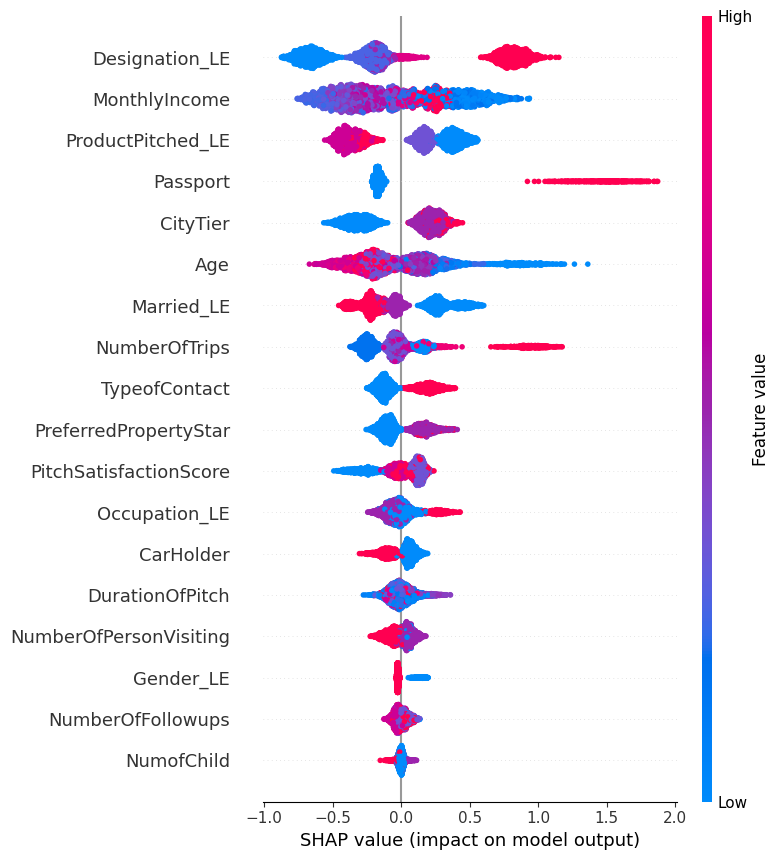

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

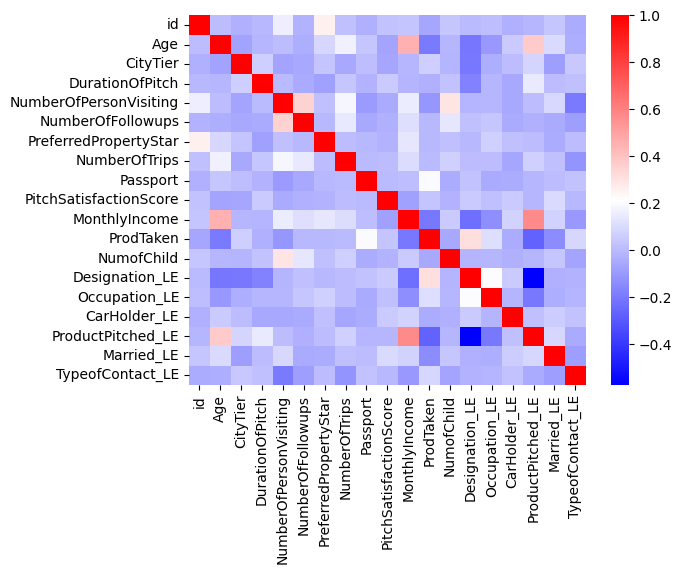

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
sns.heatmap(all_df_corr,annot=False,cmap="bwr")
plt.show()

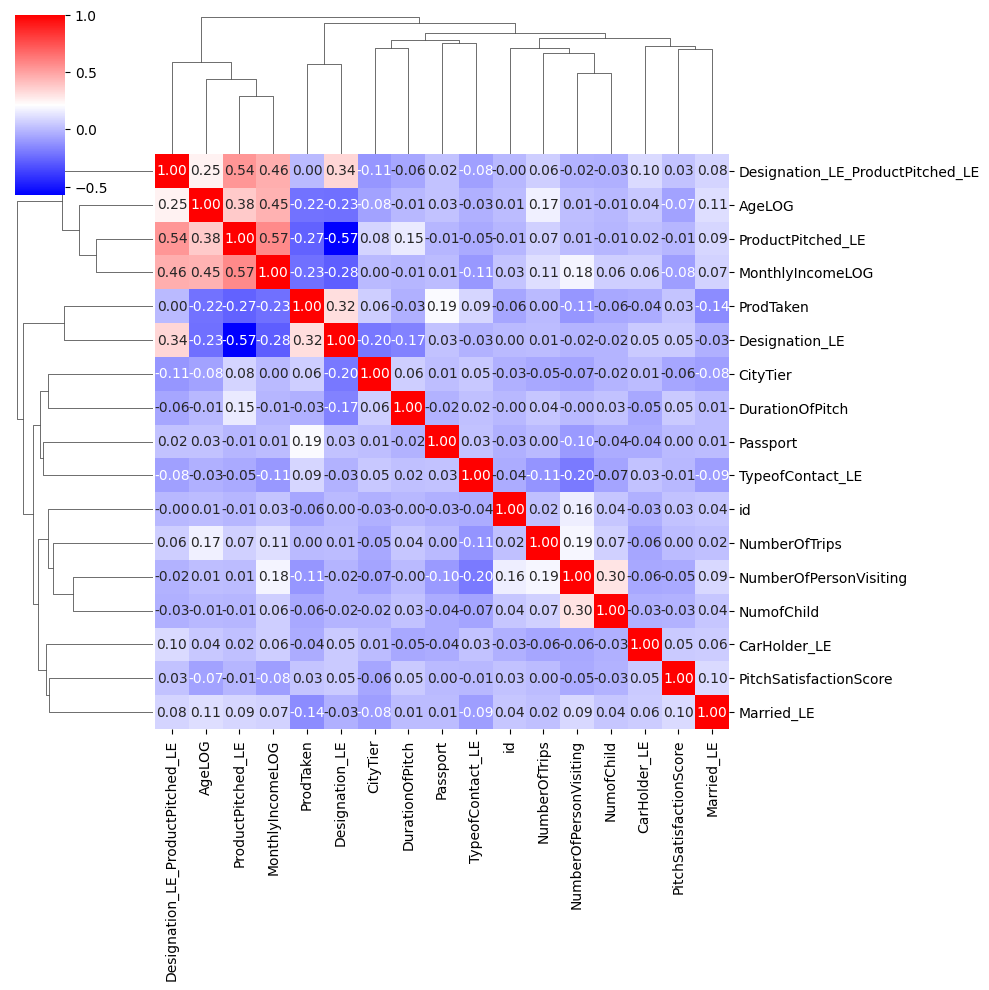

In [ ]:
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-23 22:55:14,290] A new study created in memory with name: no-name-0c3dc397-40ea-4441-984f-74e39ab25c52
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858494	valid's auc: 0.824189
[200]	train's auc: 0.863499	valid's auc: 0.825053
#########################
### Fold 2
#########################
[100]	train's auc: 0.845671	valid's auc: 0.860733
[200]	train's auc: 0.851322	valid's auc: 0.860884
#########################
### Fold 3
#########################
[100]	train's auc: 0.865468	valid's auc: 0.806947
[200]	train's auc: 0.868444	valid's auc: 0.810494


[I 2025-05-23 22:55:15,007] Trial 0 finished with value: 0.8309307717965547 and parameters: {'feature_fraction': 0.47027857235761694, 'num_leaves': 118, 'bagging_fraction': 0.8216729149766329, 'bagging_freq': 2, 'lambda_l1': 8.866810416726697, 'lambda_l2': 7.928997700506864, 'min_data_in_leaf': 93}. Best is trial 0 with value: 0.8309307717965547.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.865239	valid's auc: 0.829718
#########################
### Fold 2
#########################
[100]	train's auc: 0.857475	valid's auc: 0.856944
#########################
### Fold 3
#########################
[100]	train's auc: 0.87106	valid's auc: 0.813761
[200]	train's auc: 0.885501	valid's auc: 0.813554
[300]	train's auc: 0.894223	valid's auc: 0.817241
[400]	train's auc: 0.901537	valid's auc: 0.817957


[I 2025-05-23 22:55:15,866] Trial 1 finished with value: 0.8313046729575313 and parameters: {'feature_fraction': 0.410278213052625, 'num_leaves': 89, 'bagging_fraction': 0.6272491775830772, 'bagging_freq': 7, 'lambda_l1': 2.951725302517644, 'lambda_l2': 9.490080323255047, 'min_data_in_leaf': 92}. Best is trial 1 with value: 0.8313046729575313.


[500]	train's auc: 0.908894	valid's auc: 0.817872
#########################
### Fold 1
#########################
[100]	train's auc: 0.853537	valid's auc: 0.826286


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.86145	valid's auc: 0.826588
#########################
### Fold 2
#########################
[100]	train's auc: 0.842232	valid's auc: 0.858195
[200]	train's auc: 0.850602	valid's auc: 0.857754
#########################
### Fold 3
#########################
[100]	train's auc: 0.861082	valid's auc: 0.810749
[200]	train's auc: 0.871067	valid's auc: 0.813384
[300]	train's auc: 0.873156	valid's auc: 0.81503


[I 2025-05-23 22:55:25,333] Trial 2 finished with value: 0.8313053454416338 and parameters: {'feature_fraction': 0.5510503767528263, 'num_leaves': 153, 'bagging_fraction': 0.47306931717876366, 'bagging_freq': 7, 'lambda_l1': 6.3903910986056305, 'lambda_l2': 1.8919082342754652, 'min_data_in_leaf': 96}. Best is trial 2 with value: 0.8313053454416338.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885107	valid's auc: 0.822208
[200]	train's auc: 0.898882	valid's auc: 0.822842
[300]	train's auc: 0.904462	valid's auc: 0.822298
#########################
### Fold 2
#########################
[100]	train's auc: 0.881059	valid's auc: 0.854721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,106] Trial 3 finished with value: 0.8274600813436772 and parameters: {'feature_fraction': 0.6302747632897231, 'num_leaves': 141, 'bagging_fraction': 0.9510923261468888, 'bagging_freq': 1, 'lambda_l1': 4.427073679976076, 'lambda_l2': 7.927854935410063, 'min_data_in_leaf': 69}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.888566	valid's auc: 0.810743
[200]	train's auc: 0.902941	valid's auc: 0.811222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858058	valid's auc: 0.82396
[200]	train's auc: 0.866701	valid's auc: 0.823827
#########################
### Fold 2
#########################
[100]	train's auc: 0.847148	valid's auc: 0.85602
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,714] Trial 4 finished with value: 0.8269775740001507 and parameters: {'feature_fraction': 0.9093131428472672, 'num_leaves': 68, 'bagging_fraction': 0.5835296405971037, 'bagging_freq': 6, 'lambda_l1': 8.062303126613227, 'lambda_l2': 6.722108090550263, 'min_data_in_leaf': 74}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.863326	valid's auc: 0.80644
#########################
### Fold 1
#########################
[100]	train's auc: 0.849248	valid's auc: 0.821398


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.854194	valid's auc: 0.824618
[300]	train's auc: 0.856671	valid's auc: 0.825857
#########################
### Fold 2
#########################
[100]	train's auc: 0.834558	valid's auc: 0.856379
[200]	train's auc: 0.841498	valid's auc: 0.859083
[300]	train's auc: 0.847607	valid's auc: 0.861204
[400]	train's auc: 0.849816	valid's auc: 0.861959
#########################
### Fold 3
#########################
[100]	train's auc: 0.856135	valid's auc: 0.807603


[I 2025-05-23 22:55:27,759] Trial 5 finished with value: 0.8318668696672011 and parameters: {'feature_fraction': 0.4892803565530008, 'num_leaves': 66, 'bagging_fraction': 0.47117590871181975, 'bagging_freq': 4, 'lambda_l1': 9.685672812181542, 'lambda_l2': 8.079852211254806, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.862258	valid's auc: 0.809577
[300]	train's auc: 0.8649	valid's auc: 0.812407
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874341	valid's auc: 0.824776
[200]	train's auc: 0.877684	valid's auc: 0.826298
#########################
### Fold 2
#########################
[100]	train's auc: 0.867292	valid's auc: 0.858074
#########################
### Fold 3
#########################
[100]	train's auc: 0.877358	valid's auc: 0.81554


[I 2025-05-23 22:55:28,427] Trial 6 finished with value: 0.8298437012449026 and parameters: {'feature_fraction': 0.4290100582682084, 'num_leaves': 224, 'bagging_fraction': 0.9800176852871282, 'bagging_freq': 2, 'lambda_l1': 6.573475136355986, 'lambda_l2': 2.6873318065642566, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.882446	valid's auc: 0.816651
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86314	valid's auc: 0.823241
[200]	train's auc: 0.864166	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.854165	valid's auc: 0.858394
[200]	train's auc: 0.858759	valid's auc: 0.859754
#########################
### Fold 3
#########################
[100]	train's auc: 0.868472	valid's auc: 0.806887


[I 2025-05-23 22:55:29,272] Trial 7 finished with value: 0.8306483284735149 and parameters: {'feature_fraction': 0.6965812609701174, 'num_leaves': 124, 'bagging_fraction': 0.8352582702580358, 'bagging_freq': 3, 'lambda_l1': 9.9124539929173, 'lambda_l2': 6.332234345518537, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.87443	valid's auc: 0.811575
[300]	train's auc: 0.877127	valid's auc: 0.812437
[400]	train's auc: 0.877375	valid's auc: 0.812674
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.895998	valid's auc: 0.820123
#########################
### Fold 2
#########################
[100]	train's auc: 0.898629	valid's auc: 0.849591
#########################
### Fold 3
#########################
[100]	train's auc: 0.900734	valid's auc: 0.807974


[I 2025-05-23 22:55:30,174] Trial 8 finished with value: 0.8256497541398122 and parameters: {'feature_fraction': 0.9645785932858161, 'num_leaves': 84, 'bagging_fraction': 0.6173500565284545, 'bagging_freq': 7, 'lambda_l1': 1.506220304483326, 'lambda_l2': 9.113061066317186, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.932008	valid's auc: 0.805963
#########################
### Fold 1
#########################
[100]	train's auc: 0.861717	valid's auc: 0.822754
#########################
### Fold 2
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.852933	valid's auc: 0.85454
[200]	train's auc: 0.85765	valid's auc: 0.855506
#########################
### Fold 3
#########################
[100]	train's auc: 0.870959	valid's auc: 0.809352


[I 2025-05-23 22:55:30,710] Trial 9 finished with value: 0.8282499139220348 and parameters: {'feature_fraction': 0.9168982346633602, 'num_leaves': 183, 'bagging_fraction': 0.7656830827002284, 'bagging_freq': 3, 'lambda_l1': 9.73856898588278, 'lambda_l2': 1.0441804594684845, 'min_data_in_leaf': 69}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.871397	valid's auc: 0.809832
#########################
### Fold 1
#########################
[100]	train's auc: 0.853385	valid's auc: 0.823422


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865829	valid's auc: 0.824117
#########################
### Fold 2
#########################
[100]	train's auc: 0.842815	valid's auc: 0.858213
#########################
### Fold 3
#########################
[100]	train's auc: 0.863705	valid's auc: 0.809036
[200]	train's auc: 0.873115	valid's auc: 0.811441


[I 2025-05-23 22:55:31,366] Trial 10 finished with value: 0.8291977802644745 and parameters: {'feature_fraction': 0.7958046397680866, 'num_leaves': 4, 'bagging_fraction': 0.4191277569707914, 'bagging_freq': 5, 'lambda_l1': 5.13353170614043, 'lambda_l2': 4.236487488493048, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.8318668696672011.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859271	valid's auc: 0.821271
[200]	train's auc: 0.869682	valid's auc: 0.823392
[300]	train's auc: 0.873088	valid's auc: 0.823773
#########################
### Fold 2
#########################
[100]	train's auc: 0.848644	valid's auc: 0.856026


[I 2025-05-23 22:55:32,096] Trial 11 finished with value: 0.8278763490031096 and parameters: {'feature_fraction': 0.5504722025206561, 'num_leaves': 32, 'bagging_fraction': 0.40922172155738934, 'bagging_freq': 5, 'lambda_l1': 6.772840095359229, 'lambda_l2': 0.14726236072274634, 'min_data_in_leaf': 35}. Best is trial 5 with value: 0.8318668696672011.


#########################
### Fold 3
#########################
[100]	train's auc: 0.864257	valid's auc: 0.812413
[200]	train's auc: 0.86924	valid's auc: 0.814994


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859988	valid's auc: 0.821416
[200]	train's auc: 0.867639	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.846468	valid's auc: 0.856213
[200]	train's auc: 0.860985	valid's auc: 0.855494
#########################
### Fold 3
#########################
[100]	train's auc: 0.868453	valid's auc: 0.815315
[200]	train's auc: 0.874616	valid's auc: 0.817975


[I 2025-05-23 22:55:32,837] Trial 12 finished with value: 0.831533317552373 and parameters: {'feature_fraction': 0.560754625122817, 'num_leaves': 173, 'bagging_fraction': 0.5142473093049356, 'bagging_freq': 4, 'lambda_l1': 6.860781006199174, 'lambda_l2': 3.6860209221079776, 'min_data_in_leaf': 48}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.875069	valid's auc: 0.818413
#########################
### Fold 1
#########################
[100]	train's auc: 0.857156	valid's auc: 0.81996


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865925	valid's auc: 0.822449
#########################
### Fold 2
#########################
[100]	train's auc: 0.844584	valid's auc: 0.85631
[200]	train's auc: 0.855385	valid's auc: 0.857609
#########################
### Fold 3
#########################
[100]	train's auc: 0.865795	valid's auc: 0.81005
[200]	train's auc: 0.870761	valid's auc: 0.811326


[I 2025-05-23 22:55:33,670] Trial 13 finished with value: 0.8296093405351898 and parameters: {'feature_fraction': 0.5724944578342401, 'num_leaves': 246, 'bagging_fraction': 0.5218127994007979, 'bagging_freq': 4, 'lambda_l1': 7.868529097881106, 'lambda_l2': 4.150893742469795, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.874331	valid's auc: 0.813676
[400]	train's auc: 0.876633	valid's auc: 0.814726
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868201	valid's auc: 0.819942
[200]	train's auc: 0.882283	valid's auc: 0.819344
#########################
### Fold 2
#########################
[100]	train's auc: 0.859947	valid's auc: 0.857234
#########################
### Fold 3
#########################
[100]	train's auc: 0.878122	valid's auc: 0.815006
[200]	train's auc: 0.888356	valid's auc: 0.817241
[300]	train's auc: 0.896453	valid's auc: 0.820672


[I 2025-05-23 22:55:34,725] Trial 14 finished with value: 0.8295205726336629 and parameters: {'feature_fraction': 0.5094008998133707, 'num_leaves': 188, 'bagging_fraction': 0.5209395684958936, 'bagging_freq': 4, 'lambda_l1': 4.848775647049762, 'lambda_l2': 5.49351569037482, 'min_data_in_leaf': 36}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.904	valid's auc: 0.82174
[500]	train's auc: 0.910096	valid's auc: 0.822166
[600]	train's auc: 0.913889	valid's auc: 0.820775


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.969015	valid's auc: 0.813132
#########################
### Fold 2
#########################
[100]	train's auc: 0.969795	valid's auc: 0.834721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:38,328] Trial 15 finished with value: 0.8198246968441666 and parameters: {'feature_fraction': 0.6738820513306144, 'num_leaves': 44, 'bagging_fraction': 0.6852346546750625, 'bagging_freq': 5, 'lambda_l1': 0.38005314419521774, 'lambda_l2': 3.04892722035004, 'min_data_in_leaf': 24}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.966275	valid's auc: 0.803662
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.856397	valid's auc: 0.824038
[200]	train's auc: 0.862754	valid's auc: 0.826208
[300]	train's auc: 0.865987	valid's auc: 0.827621
#########################
### Fold 2
#########################
[100]	train's auc: 0.844015	valid's auc: 0.859301
#########################
### Fold 3
#########################
[100]	train's auc: 0.864419	valid's auc: 0.807111
[200]	train's auc: 0.869997	valid's auc: 0.810901
[300]	train's auc: 0.874683	valid's auc: 0.812036


[I 2025-05-23 22:55:39,264] Trial 16 finished with value: 0.8290518512142374 and parameters: {'feature_fraction': 0.621928106600609, 'num_leaves': 172, 'bagging_fraction': 0.5227886700034061, 'bagging_freq': 3, 'lambda_l1': 8.066623418175256, 'lambda_l2': 4.660865807815339, 'min_data_in_leaf': 58}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.878515	valid's auc: 0.813087
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.91168	valid's auc: 0.820727
#########################
### Fold 2
#########################
[100]	train's auc: 0.90824	valid's auc: 0.853101
[200]	train's auc: 0.934201	valid's auc: 0.847996
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:40,131] Trial 17 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.7867546006558469, 'num_leaves': 209, 'bagging_fraction': 0.7029302211145672, 'bagging_freq': 4, 'lambda_l1': 3.766837549505833, 'lambda_l2': 7.621459971788497, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.91156	valid's auc: 0.808095
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858165	valid's auc: 0.823948
[200]	train's auc: 0.866032	valid's auc: 0.826389
#########################
### Fold 2
#########################
[100]	train's auc: 0.849117	valid's auc: 0.856358
[200]	train's auc: 0.858672	valid's auc: 0.85657
#########################
### Fold 3
#########################
[100]	train's auc: 0.8623	valid's auc: 0.814818


[I 2025-05-23 22:55:40,874] Trial 18 finished with value: 0.8331028954475516 and parameters: {'feature_fraction': 0.480504729283548, 'num_leaves': 101, 'bagging_fraction': 0.45305578659905, 'bagging_freq': 6, 'lambda_l1': 5.823355384805122, 'lambda_l2': 5.726410326017227, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.872284	valid's auc: 0.817599
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.88088	valid's auc: 0.820757
[200]	train's auc: 0.900139	valid's auc: 0.821797
#########################
### Fold 2
#########################
[100]	train's auc: 0.879101	valid's auc: 0.85347
[200]	train's auc: 0.899624	valid's auc: 0.848981
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:41,724] Trial 19 finished with value: 0.8326846103358116 and parameters: {'feature_fraction': 0.47594707993703206, 'num_leaves': 113, 'bagging_fraction': 0.46829070707831877, 'bagging_freq': 6, 'lambda_l1': 2.6772246776279713, 'lambda_l2': 5.698582875568366, 'min_data_in_leaf': 25}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.884481	valid's auc: 0.818212
[200]	train's auc: 0.908072	valid's auc: 0.820155
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.911687	valid's auc: 0.825724
#########################
### Fold 2
#########################
[100]	train's auc: 0.914539	valid's auc: 0.843833
#########################
### Fold 3
#########################
[100]	train's auc: 0.915969	valid's auc: 0.810852


[I 2025-05-23 22:55:42,460] Trial 20 finished with value: 0.8269194041252864 and parameters: {'feature_fraction': 0.7947331435478799, 'num_leaves': 106, 'bagging_fraction': 0.5848106266228199, 'bagging_freq': 6, 'lambda_l1': 2.1781604113664352, 'lambda_l2': 6.105899347013368, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.948957	valid's auc: 0.81104
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.89842	valid's auc: 0.820909
#########################
### Fold 2
#########################
[100]	train's auc: 0.898144	valid's auc: 0.851621
#########################
### Fold 3
#########################
[100]	train's auc: 0.901421	valid's auc: 0.820095


[I 2025-05-23 22:55:43,149] Trial 21 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.4685466067319679, 'num_leaves': 53, 'bagging_fraction': 0.4513908947165414, 'bagging_freq': 6, 'lambda_l1': 0.4500366195172689, 'lambda_l2': 7.108113522488885, 'min_data_in_leaf': 30}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.933144	valid's auc: 0.815486
#########################
### Fold 1
#########################
[100]	train's auc: 0.860276	valid's auc: 0.821887


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.869644	valid's auc: 0.82602
[300]	train's auc: 0.87628	valid's auc: 0.823519
#########################
### Fold 2
#########################
[100]	train's auc: 0.851187	valid's auc: 0.852685
[200]	train's auc: 0.862376	valid's auc: 0.852268
[300]	train's auc: 0.869429	valid's auc: 0.856098
[400]	train's auc: 0.877741	valid's auc: 0.855023
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:44,106] Trial 22 finished with value: 0.8320847545164032 and parameters: {'feature_fraction': 0.4816345606091615, 'num_leaves': 79, 'bagging_fraction': 0.48482853516798996, 'bagging_freq': 6, 'lambda_l1': 5.724283307803062, 'lambda_l2': 5.3276873481663785, 'min_data_in_leaf': 42}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.866867	valid's auc: 0.815868
[200]	train's auc: 0.878172	valid's auc: 0.817957


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.855435	valid's auc: 0.823416
[200]	train's auc: 0.8646	valid's auc: 0.826008
[300]	train's auc: 0.870596	valid's auc: 0.825827
#########################
### Fold 2
#########################
[100]	train's auc: 0.842607	valid's auc: 0.856968
[200]	train's auc: 0.852931	valid's auc: 0.856219
#########################
### Fold 3
#########################
[100]	train's auc: 0.861542	valid's auc: 0.815224
[200]	train's auc: 0.87081	valid's auc: 0.815449
[300]	train's auc: 0.875654	valid's auc: 0.817599
[400]	train's auc: 0.881702	valid's auc: 0.820283
[500]	train's auc: 0.884932	valid's auc: 0.822894


[I 2025-05-23 22:55:45,180] Trial 23 finished with value: 0.8325413712219843 and parameters: {'feature_fraction': 0.4168644088111567, 'num_leaves': 98, 'bagging_fraction': 0.4048968054235994, 'bagging_freq': 6, 'lambda_l1': 5.620280807541148, 'lambda_l2': 5.271011253351733, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[600]	train's auc: 0.88789	valid's auc: 0.824054
#########################
### Fold 1
#########################
[100]	train's auc: 0.860985	valid's auc: 0.823615


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.872271	valid's auc: 0.826105
[300]	train's auc: 0.879861	valid's auc: 0.828461
[400]	train's auc: 0.885324	valid's auc: 0.826927
#########################
### Fold 2
#########################
[100]	train's auc: 0.848994	valid's auc: 0.857252
[200]	train's auc: 0.863164	valid's auc: 0.852999
#########################
### Fold 3
#########################
[100]	train's auc: 0.867216	valid's auc: 0.817058


[I 2025-05-23 22:55:46,095] Trial 24 finished with value: 0.8341062417284455 and parameters: {'feature_fraction': 0.41007277941849635, 'num_leaves': 143, 'bagging_fraction': 0.4056068234981311, 'bagging_freq': 6, 'lambda_l1': 3.5255646301896215, 'lambda_l2': 5.06243069102702, 'min_data_in_leaf': 63}. Best is trial 24 with value: 0.8341062417284455.


[200]	train's auc: 0.88122	valid's auc: 0.820107
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867971	valid's auc: 0.823126
[200]	train's auc: 0.882349	valid's auc: 0.824359
#########################
### Fold 2
#########################
[100]	train's auc: 0.86254	valid's auc: 0.859627
[200]	train's auc: 0.879988	valid's auc: 0.858751
#########################
### Fold 3
#########################
[100]	train's auc: 0.871817	valid's auc: 0.81333
[200]	train's auc: 0.887112	valid's auc: 0.819512
[300]	train's auc: 0.895675	valid's auc: 0.821048


[I 2025-05-23 22:55:47,128] Trial 25 finished with value: 0.8327666533963137 and parameters: {'feature_fraction': 0.40506845124344865, 'num_leaves': 154, 'bagging_fraction': 0.5713778164208194, 'bagging_freq': 5, 'lambda_l1': 3.6953128541438076, 'lambda_l2': 5.973331169928623, 'min_data_in_leaf': 60}. Best is trial 24 with value: 0.8341062417284455.


[400]	train's auc: 0.903154	valid's auc: 0.821419
[500]	train's auc: 0.909539	valid's auc: 0.820544
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870109	valid's auc: 0.824177
#########################
### Fold 2
#########################
[100]	train's auc: 0.864319	valid's auc: 0.858038
#########################
### Fold 3
#########################
[100]	train's auc: 0.875323	valid's auc: 0.817131
[200]	train's auc: 0.889825	valid's auc: 0.820605


[I 2025-05-23 22:55:47,802] Trial 26 finished with value: 0.8312834897083032 and parameters: {'feature_fraction': 0.4291979769458116, 'num_leaves': 140, 'bagging_fraction': 0.5553898682136359, 'bagging_freq': 5, 'lambda_l1': 3.7266761751137976, 'lambda_l2': 3.2314886228587274, 'min_data_in_leaf': 59}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870967	valid's auc: 0.826492
[200]	train's auc: 0.8871	valid's auc: 0.827718
#########################
### Fold 2
#########################
[100]	train's auc: 0.867233	valid's auc: 0.855579
#########################
### Fold 3
#########################
[100]	train's auc: 0.875133	valid's auc: 0.810354
[200]	train's auc: 0.891861	valid's auc: 0.817058
[300]	train's auc: 0.899356	valid's auc: 0.819481


[I 2025-05-23 22:55:51,443] Trial 27 finished with value: 0.8286164177578842 and parameters: {'feature_fraction': 0.5211951803231629, 'num_leaves': 160, 'bagging_fraction': 0.6325412930520735, 'bagging_freq': 5, 'lambda_l1': 4.021064979952011, 'lambda_l2': 4.85317478493218, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862164	valid's auc: 0.82744
[200]	train's auc: 0.875433	valid's auc: 0.829053
#########################
### Fold 2
#########################
[100]	train's auc: 0.852053	valid's auc: 0.860135
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,196] Trial 28 finished with value: 0.835053771828834 and parameters: {'feature_fraction': 0.40338538741469376, 'num_leaves': 133, 'bagging_fraction': 0.44650127139645795, 'bagging_freq': 7, 'lambda_l1': 3.107900276611632, 'lambda_l2': 7.001696815025252, 'min_data_in_leaf': 63}. Best is trial 28 with value: 0.835053771828834.


[100]	train's auc: 0.868938	valid's auc: 0.813852
[200]	train's auc: 0.883852	valid's auc: 0.819828
[300]	train's auc: 0.890358	valid's auc: 0.819184


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862278	valid's auc: 0.827948
[200]	train's auc: 0.876159	valid's auc: 0.829162
#########################
### Fold 2
#########################
[100]	train's auc: 0.853312	valid's auc: 0.858751
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,879] Trial 29 finished with value: 0.8362803828317499 and parameters: {'feature_fraction': 0.45705463013508557, 'num_leaves': 120, 'bagging_fraction': 0.44209794224057836, 'bagging_freq': 7, 'lambda_l1': 2.2276613705975654, 'lambda_l2': 8.584681328939595, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867662	valid's auc: 0.817125
[200]	train's auc: 0.882991	valid's auc: 0.821212
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.898249	valid's auc: 0.82144
#########################
### Fold 2
#########################
[100]	train's auc: 0.899151	valid's auc: 0.848473
#########################
### Fold 3
#########################
[100]	train's auc: 0.901273	valid's auc: 0.811374


[I 2025-05-23 22:55:53,530] Trial 30 finished with value: 0.8263185395797243 and parameters: {'feature_fraction': 0.6144999835106199, 'num_leaves': 131, 'bagging_fraction': 0.8550090265852675, 'bagging_freq': 7, 'lambda_l1': 1.2345480560392652, 'lambda_l2': 8.82085336081849, 'min_data_in_leaf': 85}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.860926	valid's auc: 0.825893
[200]	train's auc: 0.874499	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.854665	valid's auc: 0.858141
#########################
### Fold 3
#########################
[100]	train's auc: 0.868263	valid's auc: 0.812959
[200]	train's auc: 0.883264	valid's auc: 0.818121
[300]	train's auc: 0.890075	valid's auc: 0.817058


[I 2025-05-23 22:55:54,294] Trial 31 finished with value: 0.8339757798125652 and parameters: {'feature_fraction': 0.45807170882012804, 'num_leaves': 121, 'bagging_fraction': 0.43797109164769804, 'bagging_freq': 7, 'lambda_l1': 2.885642414366064, 'lambda_l2': 9.873485332832669, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859164	valid's auc: 0.827331
[200]	train's auc: 0.871251	valid's auc: 0.827059
#########################
### Fold 2
#########################
[100]	train's auc: 0.847422	valid's auc: 0.860086
#########################
### Fold 3
#########################
[100]	train's auc: 0.864222	valid's auc: 0.813676


[I 2025-05-23 22:55:54,999] Trial 32 finished with value: 0.8339804872012826 and parameters: {'feature_fraction': 0.44582558315157866, 'num_leaves': 122, 'bagging_fraction': 0.4340505173304712, 'bagging_freq': 7, 'lambda_l1': 2.944548989232467, 'lambda_l2': 9.955465153341418, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.877391	valid's auc: 0.816445
[300]	train's auc: 0.884095	valid's auc: 0.814398
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.859068	valid's auc: 0.825718
[200]	train's auc: 0.872561	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.849913	valid's auc: 0.857192
#########################
### Fold 3
#########################
[100]	train's auc: 0.864719	valid's auc: 0.812067


[I 2025-05-23 22:55:55,721] Trial 33 finished with value: 0.8326045847276169 and parameters: {'feature_fraction': 0.4401511558111197, 'num_leaves': 137, 'bagging_fraction': 0.4015148240802163, 'bagging_freq': 7, 'lambda_l1': 2.066912586787067, 'lambda_l2': 8.486712136268586, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.880603	valid's auc: 0.818413
[300]	train's auc: 0.888385	valid's auc: 0.816208
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.855725	valid's auc: 0.827464
[200]	train's auc: 0.868355	valid's auc: 0.828951
#########################
### Fold 2
#########################
[100]	train's auc: 0.844352	valid's auc: 0.858092
#########################
### Fold 3
#########################
[100]	train's auc: 0.861965	valid's auc: 0.81271


[I 2025-05-23 22:55:56,476] Trial 34 finished with value: 0.8336946814577303 and parameters: {'feature_fraction': 0.40387285898556513, 'num_leaves': 151, 'bagging_fraction': 0.4405327673714225, 'bagging_freq': 7, 'lambda_l1': 2.969675893290621, 'lambda_l2': 9.517113295078829, 'min_data_in_leaf': 98}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.874719	valid's auc: 0.817417
[300]	train's auc: 0.880001	valid's auc: 0.817319
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873352	valid's auc: 0.828298
#########################
### Fold 2
#########################
[100]	train's auc: 0.871413	valid's auc: 0.856902
[200]	train's auc: 0.894661	valid's auc: 0.851512
#########################
### Fold 3
#########################
[100]	train's auc: 0.876598	valid's auc: 0.811781


[I 2025-05-23 22:55:57,290] Trial 35 finished with value: 0.8311795909144709 and parameters: {'feature_fraction': 0.5209599100156009, 'num_leaves': 121, 'bagging_fraction': 0.4956808695202633, 'bagging_freq': 7, 'lambda_l1': 1.1519049856023644, 'lambda_l2': 7.091817864285634, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.899028	valid's auc: 0.812394
[300]	train's auc: 0.911797	valid's auc: 0.813973
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858444	valid's auc: 0.828346
[200]	train's auc: 0.871264	valid's auc: 0.828226
#########################
### Fold 2
#########################
[100]	train's auc: 0.851701	valid's auc: 0.857742
[200]	train's auc: 0.867721	valid's auc: 0.857355
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,056] Trial 36 finished with value: 0.8345823604729984 and parameters: {'feature_fraction': 0.4485368497757733, 'num_leaves': 97, 'bagging_fraction': 0.4876706876060213, 'bagging_freq': 7, 'lambda_l1': 3.2756964964826585, 'lambda_l2': 8.379725664753842, 'min_data_in_leaf': 93}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867174	valid's auc: 0.812334
[200]	train's auc: 0.881078	valid's auc: 0.816336
[300]	train's auc: 0.886442	valid's auc: 0.817344


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.87491	valid's auc: 0.829132
[200]	train's auc: 0.894258	valid's auc: 0.833501
#########################
### Fold 2
#########################
[100]	train's auc: 0.871778	valid's auc: 0.858872
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,790] Trial 37 finished with value: 0.8319280657205264 and parameters: {'feature_fraction': 0.7474553515212106, 'num_leaves': 97, 'bagging_fraction': 0.5499376386865119, 'bagging_freq': 7, 'lambda_l1': 1.9972109050778049, 'lambda_l2': 7.611108680267458, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878228	valid's auc: 0.81138
[200]	train's auc: 0.898249	valid's auc: 0.812467
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860499	valid's auc: 0.826685
[200]	train's auc: 0.871622	valid's auc: 0.826232
#########################
### Fold 2
#########################
[100]	train's auc: 0.852592	valid's auc: 0.853929
#########################
### Fold 3
#########################
[100]	train's auc: 0.866243	valid's auc: 0.81067
[200]	train's auc: 0.881669	valid's auc: 0.814629
[300]	train's auc: 0.886296	valid's auc: 0.814441


[I 2025-05-23 22:55:59,648] Trial 38 finished with value: 0.8307888776509323 and parameters: {'feature_fraction': 0.5788894628507594, 'num_leaves': 73, 'bagging_fraction': 0.49449430086862506, 'bagging_freq': 6, 'lambda_l1': 4.517764261285002, 'lambda_l2': 8.051825094465409, 'min_data_in_leaf': 78}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.891846	valid's auc: 0.817162
#########################
### Fold 1
#########################
[100]	train's auc: 0.883164	valid's auc: 0.822733


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.902833	valid's auc: 0.822963
#########################
### Fold 2
#########################
[100]	train's auc: 0.881856	valid's auc: 0.854201
#########################
### Fold 3
#########################
[100]	train's auc: 0.888719	valid's auc: 0.812237
[200]	train's auc: 0.907196	valid's auc: 0.813129
[300]	train's auc: 0.91595	valid's auc: 0.812686


[I 2025-05-23 22:56:00,499] Trial 39 finished with value: 0.8282583199733159 and parameters: {'feature_fraction': 0.5215861884434758, 'num_leaves': 194, 'bagging_fraction': 0.9004873355270997, 'bagging_freq': 1, 'lambda_l1': 3.367474242579695, 'lambda_l2': 6.634637913820147, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.863228	valid's auc: 0.824812
#########################
### Fold 2
#########################
[100]	train's auc: 0.85589	valid's auc: 0.857011
#########################
### Fold 3
#########################
[100]	train's auc: 0.869619	valid's auc: 0.811781
[200]	train's auc: 0.882603	valid's auc: 0.812085
[300]	train's auc: 0.888352	valid's auc: 0.814805


[I 2025-05-23 22:56:04,206] Trial 40 finished with value: 0.8282320930933194 and parameters: {'feature_fraction': 0.4003313544769424, 'num_leaves': 167, 'bagging_fraction': 0.6225062402628808, 'bagging_freq': 7, 'lambda_l1': 4.365994640054209, 'lambda_l2': 8.547581136252862, 'min_data_in_leaf': 70}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.894328	valid's auc: 0.8167
[500]	train's auc: 0.900315	valid's auc: 0.816718


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859641	valid's auc: 0.828679
[200]	train's auc: 0.872471	valid's auc: 0.829537
#########################
### Fold 2
#########################
[100]	train's auc: 0.848132	valid's auc: 0.85947
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:04,936] Trial 41 finished with value: 0.8350820161611381 and parameters: {'feature_fraction': 0.448128954307543, 'num_leaves': 146, 'bagging_fraction': 0.4346965534851677, 'bagging_freq': 7, 'lambda_l1': 2.40422586810867, 'lambda_l2': 9.228947765826637, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.863455	valid's auc: 0.813062
[200]	train's auc: 0.878359	valid's auc: 0.817532
[300]	train's auc: 0.885152	valid's auc: 0.818619


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859458	valid's auc: 0.826945
[200]	train's auc: 0.87361	valid's auc: 0.825682
#########################
### Fold 2
#########################
[100]	train's auc: 0.8515	valid's auc: 0.857228
#########################
### Fold 3
#########################
[100]	train's auc: 0.865849	valid's auc: 0.814022
[200]	train's auc: 0.881719	valid's auc: 0.817453


[I 2025-05-23 22:56:06,210] Trial 42 finished with value: 0.8337168734331121 and parameters: {'feature_fraction': 0.4520968864010434, 'num_leaves': 146, 'bagging_fraction': 0.46485267363921895, 'bagging_freq': 7, 'lambda_l1': 2.3860259531352312, 'lambda_l2': 9.199702693676125, 'min_data_in_leaf': 99}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.887661	valid's auc: 0.818358
#########################
### Fold 1
#########################
[100]	train's auc: 0.866777	valid's auc: 0.829229


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.881845	valid's auc: 0.829954
#########################
### Fold 2
#########################
[100]	train's auc: 0.859864	valid's auc: 0.855234
[200]	train's auc: 0.881532	valid's auc: 0.849627
#########################
### Fold 3
#########################
[100]	train's auc: 0.872586	valid's auc: 0.812334


[I 2025-05-23 22:56:07,490] Trial 43 finished with value: 0.8350604966698588 and parameters: {'feature_fraction': 0.5027744898191268, 'num_leaves': 90, 'bagging_fraction': 0.43323788636740274, 'bagging_freq': 6, 'lambda_l1': 1.664542261222835, 'lambda_l2': 8.273910414490384, 'min_data_in_leaf': 80}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891547	valid's auc: 0.814951
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868416	valid's auc: 0.829452
#########################
### Fold 2
#########################
[100]	train's auc: 0.862574	valid's auc: 0.857089
[200]	train's auc: 0.881109	valid's auc: 0.854926
#########################
### Fold 3
#########################
[100]	train's auc: 0.871818	valid's auc: 0.812613
[200]	train's auc: 0.891465	valid's auc: 0.814101


[I 2025-05-23 22:56:08,246] Trial 44 finished with value: 0.83210560152358 and parameters: {'feature_fraction': 0.5079331928964885, 'num_leaves': 83, 'bagging_fraction': 0.49337618472750117, 'bagging_freq': 7, 'lambda_l1': 1.5603443639290622, 'lambda_l2': 8.33838772665331, 'min_data_in_leaf': 94}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.901192	valid's auc: 0.818048
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867441	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.859628	valid's auc: 0.858249
#########################
### Fold 3
#########################
[100]	train's auc: 0.872779	valid's auc: 0.813311
[200]	train's auc: 0.892553	valid's auc: 0.816633


[I 2025-05-23 22:56:08,890] Trial 45 finished with value: 0.8319516026641129 and parameters: {'feature_fraction': 0.5434717417334411, 'num_leaves': 111, 'bagging_fraction': 0.42523446687170025, 'bagging_freq': 7, 'lambda_l1': 0.8517065324429067, 'lambda_l2': 8.995570642065063, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.872329	valid's auc: 0.827779
[200]	train's auc: 0.889234	valid's auc: 0.829519
#########################
### Fold 2
#########################
[100]	train's auc: 0.866047	valid's auc: 0.85376
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:09,500] Trial 46 finished with value: 0.8320571826682016 and parameters: {'feature_fraction': 0.49952982897790066, 'num_leaves': 55, 'bagging_fraction': 0.5396508206922758, 'bagging_freq': 6, 'lambda_l1': 1.8320020414497762, 'lambda_l2': 7.485793827927812, 'min_data_in_leaf': 90}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.874183	valid's auc: 0.820411
[200]	train's auc: 0.894722	valid's auc: 0.819342
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.887794	valid's auc: 0.821319
[200]	train's auc: 0.911784	valid's auc: 0.822147
#########################
### Fold 2
#########################
[100]	train's auc: 0.889344	valid's auc: 0.851657
#########################
### Fold 3
#########################
[100]	train's auc: 0.890885	valid's auc: 0.813123


[I 2025-05-23 22:56:10,236] Trial 47 finished with value: 0.828450650426624 and parameters: {'feature_fraction': 0.5847271988101193, 'num_leaves': 86, 'bagging_fraction': 0.7694491956846389, 'bagging_freq': 7, 'lambda_l1': 2.4795290602565263, 'lambda_l2': 8.059581967125169, 'min_data_in_leaf': 72}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914713	valid's auc: 0.813506
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.872679	valid's auc: 0.825174
[200]	train's auc: 0.893466	valid's auc: 0.826655
#########################
### Fold 2
#########################
[100]	train's auc: 0.870548	valid's auc: 0.853089
#########################
### Fold 3
#########################
[100]	train's auc: 0.88114	valid's auc: 0.817593


[I 2025-05-23 22:56:10,954] Trial 48 finished with value: 0.83265972842402 and parameters: {'feature_fraction': 0.4371791180376162, 'num_leaves': 132, 'bagging_fraction': 0.46962242049984615, 'bagging_freq': 6, 'lambda_l1': 0.09373301416898472, 'lambda_l2': 9.338981655271866, 'min_data_in_leaf': 79}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.905111	valid's auc: 0.817441
#########################
### Fold 1
#########################
[100]	train's auc: 0.875827	valid's auc: 0.830721


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.873616	valid's auc: 0.856443
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:11,504] Trial 49 finished with value: 0.8321288022251153 and parameters: {'feature_fraction': 0.5386196118200486, 'num_leaves': 91, 'bagging_fraction': 0.5920022284822103, 'bagging_freq': 7, 'lambda_l1': 1.5678732623303584, 'lambda_l2': 7.042639158242492, 'min_data_in_leaf': 100}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878551	valid's auc: 0.813482
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.871478	valid's auc: 0.831126
[200]	train's auc: 0.889965	valid's auc: 0.830957
#########################
### Fold 2
#########################
[100]	train's auc: 0.863753	valid's auc: 0.852691
#########################
### Fold 3
#########################
[100]	train's auc: 0.876838	valid's auc: 0.81288


[I 2025-05-23 22:56:12,187] Trial 50 finished with value: 0.8245122472804743 and parameters: {'feature_fraction': 0.8867819317577077, 'num_leaves': 26, 'bagging_fraction': 0.4361871650581403, 'bagging_freq': 2, 'lambda_l1': 0.8098403185841458, 'lambda_l2': 8.669341250534188, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895124	valid's auc: 0.813026
#########################
### Fold 1
#########################
[100]	train's auc: 0.866967	valid's auc: 0.823942


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880447	valid's auc: 0.826878
#########################
### Fold 2
#########################
[100]	train's auc: 0.857923	valid's auc: 0.855911
[200]	train's auc: 0.874158	valid's auc: 0.851579
#########################
### Fold 3
#########################
[100]	train's auc: 0.873399	valid's auc: 0.813761


[I 2025-05-23 22:56:12,976] Trial 51 finished with value: 0.8324573107091748 and parameters: {'feature_fraction': 0.46150873053232483, 'num_leaves': 131, 'bagging_fraction': 0.41265101714215957, 'bagging_freq': 6, 'lambda_l1': 3.26473849968669, 'lambda_l2': 2.082735823120961, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891479	valid's auc: 0.815425
#########################
### Fold 1
#########################
[100]	train's auc: 0.86236	valid's auc: 0.826123


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.874894	valid's auc: 0.827343
#########################
### Fold 2
#########################
[100]	train's auc: 0.854599	valid's auc: 0.855265
#########################
### Fold 3
#########################
[100]	train's auc: 0.869977	valid's auc: 0.815625
[200]	train's auc: 0.883998	valid's auc: 0.815935


[I 2025-05-23 22:56:13,730] Trial 52 finished with value: 0.8278319650523461 and parameters: {'feature_fraction': 0.42343174463723954, 'num_leaves': 112, 'bagging_fraction': 0.5101097326569876, 'bagging_freq': 6, 'lambda_l1': 3.449274997456781, 'lambda_l2': 8.281909890671987, 'min_data_in_leaf': 67}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890529	valid's auc: 0.8135
#########################
### Fold 1
#########################
[100]	train's auc: 0.8661	valid's auc: 0.827404


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.882254	valid's auc: 0.827676
#########################
### Fold 2
#########################
[100]	train's auc: 0.861531	valid's auc: 0.856908
#########################
### Fold 3
#########################
[100]	train's auc: 0.872015	valid's auc: 0.815152


[I 2025-05-23 22:56:17,284] Trial 53 finished with value: 0.834040338286403 and parameters: {'feature_fraction': 0.4805649070922209, 'num_leaves': 178, 'bagging_fraction': 0.46070384543194065, 'bagging_freq': 7, 'lambda_l1': 2.533477498522967, 'lambda_l2': 9.559609403311121, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.890084	valid's auc: 0.817568
[300]	train's auc: 0.897572	valid's auc: 0.817896
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860367	valid's auc: 0.826413
[200]	train's auc: 0.872523	valid's auc: 0.828691
#########################
### Fold 2
#########################
[100]	train's auc: 0.850415	valid's auc: 0.854026
[200]	train's auc: 0.866889	valid's auc: 0.849482
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:18,102] Trial 54 finished with value: 0.8321930244569018 and parameters: {'feature_fraction': 0.4438814830892867, 'num_leaves': 145, 'bagging_fraction': 0.4266184577167425, 'bagging_freq': 6, 'lambda_l1': 3.128412000424267, 'lambda_l2': 6.409552713207584, 'min_data_in_leaf': 88}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.865986	valid's auc: 0.810743
[200]	train's auc: 0.881072	valid's auc: 0.816135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.857459	valid's auc: 0.826643
[200]	train's auc: 0.869031	valid's auc: 0.827229
#########################
### Fold 2
#########################
[100]	train's auc: 0.850398	valid's auc: 0.85953
#########################
### Fold 3
#########################
[100]	train's auc: 0.866248	valid's auc: 0.810949
[200]	train's auc: 0.878214	valid's auc: 0.816457


[I 2025-05-23 22:56:19,207] Trial 55 finished with value: 0.8333080030988069 and parameters: {'feature_fraction': 0.49258637605374633, 'num_leaves': 66, 'bagging_fraction': 0.4801805846661832, 'bagging_freq': 7, 'lambda_l1': 4.197684658373672, 'lambda_l2': 7.7541666892229415, 'min_data_in_leaf': 74}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.883279	valid's auc: 0.817556
[400]	train's auc: 0.888461	valid's auc: 0.819415


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858465	valid's auc: 0.825078
[200]	train's auc: 0.868192	valid's auc: 0.824902
#########################
### Fold 2
#########################
[100]	train's auc: 0.84826	valid's auc: 0.858491
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:19,909] Trial 56 finished with value: 0.8320719773184562 and parameters: {'feature_fraction': 0.6536848216172695, 'num_leaves': 158, 'bagging_fraction': 0.45289849868052945, 'bagging_freq': 6, 'lambda_l1': 4.969536579198013, 'lambda_l2': 7.2559400702094115, 'min_data_in_leaf': 81}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.864413	valid's auc: 0.811368
[200]	train's auc: 0.876873	valid's auc: 0.816336


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866797	valid's auc: 0.823199
[200]	train's auc: 0.881052	valid's auc: 0.827706
#########################
### Fold 2
#########################
[100]	train's auc: 0.858933	valid's auc: 0.857041
[200]	train's auc: 0.875483	valid's auc: 0.857688
#########################
### Fold 3
#########################
[100]	train's auc: 0.871216	valid's auc: 0.813791
[200]	train's auc: 0.890007	valid's auc: 0.81687


[I 2025-05-23 22:56:20,711] Trial 57 finished with value: 0.8337733620977201 and parameters: {'feature_fraction': 0.4629427370270085, 'num_leaves': 106, 'bagging_fraction': 0.40710681519263503, 'bagging_freq': 5, 'lambda_l1': 1.7909387391221205, 'lambda_l2': 8.840423465320006, 'min_data_in_leaf': 63}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870949	valid's auc: 0.825646
#########################
### Fold 2
#########################
[100]	train's auc: 0.865663	valid's auc: 0.857138
#########################
### Fold 3
#########################
[100]	train's auc: 0.875299	valid's auc: 0.812473


[I 2025-05-23 22:56:21,508] Trial 58 finished with value: 0.8305306437555815 and parameters: {'feature_fraction': 0.4204273800163275, 'num_leaves': 166, 'bagging_fraction': 0.6517697623446567, 'bagging_freq': 7, 'lambda_l1': 2.324341284245957, 'lambda_l2': 8.028563687551008, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.892806	valid's auc: 0.814903
[300]	train's auc: 0.902225	valid's auc: 0.817429
[400]	train's auc: 0.911143	valid's auc: 0.816488


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866094	valid's auc: 0.827495
[200]	train's auc: 0.881046	valid's auc: 0.827591
#########################
### Fold 2
#########################
[100]	train's auc: 0.860868	valid's auc: 0.857452
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:22,289] Trial 59 finished with value: 0.8308628509022046 and parameters: {'feature_fraction': 0.42953303993912556, 'num_leaves': 195, 'bagging_fraction': 0.5322274162760683, 'bagging_freq': 6, 'lambda_l1': 2.74624245509693, 'lambda_l2': 6.716804442976147, 'min_data_in_leaf': 75}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872912	valid's auc: 0.816597
[200]	train's auc: 0.890497	valid's auc: 0.818346


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867353	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.85903	valid's auc: 0.859397
[200]	train's auc: 0.876899	valid's auc: 0.857585
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:23,025] Trial 60 finished with value: 0.8351997008790712 and parameters: {'feature_fraction': 0.4005559088334328, 'num_leaves': 92, 'bagging_fraction': 0.5038753530134158, 'bagging_freq': 5, 'lambda_l1': 3.907732884338815, 'lambda_l2': 4.0744753948206345, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872663	valid's auc: 0.816749
[200]	train's auc: 0.887223	valid's auc: 0.819821


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866373	valid's auc: 0.826165
[200]	train's auc: 0.881239	valid's auc: 0.826769
[300]	train's auc: 0.889942	valid's auc: 0.82573
#########################
### Fold 2
#########################
[100]	train's auc: 0.857921	valid's auc: 0.861011
#########################
### Fold 3
#########################
[100]	train's auc: 0.872027	valid's auc: 0.814362
[200]	train's auc: 0.886619	valid's auc: 0.820168


[I 2025-05-23 22:56:23,848] Trial 61 finished with value: 0.8350672215108836 and parameters: {'feature_fraction': 0.4052910840821733, 'num_leaves': 75, 'bagging_fraction': 0.5112783335349782, 'bagging_freq': 5, 'lambda_l1': 3.9422764223866658, 'lambda_l2': 4.162290358667264, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864029	valid's auc: 0.824848
[200]	train's auc: 0.877735	valid's auc: 0.826292
[300]	train's auc: 0.884998	valid's auc: 0.824649
#########################
### Fold 2
#########################
[100]	train's auc: 0.855077	valid's auc: 0.860068
[200]	train's auc: 0.870116	valid's auc: 0.857875
#########################
### Fold 3
#########################
[100]	train's auc: 0.870384	valid's auc: 0.814957


[I 2025-05-23 22:56:24,691] Trial 62 finished with value: 0.8356569900687549 and parameters: {'feature_fraction': 0.4008281397744597, 'num_leaves': 96, 'bagging_fraction': 0.5108380152116213, 'bagging_freq': 5, 'lambda_l1': 4.563868264516446, 'lambda_l2': 3.72572625689377, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.883893	valid's auc: 0.820423
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.863401	valid's auc: 0.826165
#########################
### Fold 2
#########################
[100]	train's auc: 0.854172	valid's auc: 0.860878
#########################
### Fold 3
#########################
[100]	train's auc: 0.869497	valid's auc: 0.815886


[I 2025-05-23 22:56:25,382] Trial 63 finished with value: 0.8352212203703504 and parameters: {'feature_fraction': 0.416356662265913, 'num_leaves': 76, 'bagging_fraction': 0.5084463883780299, 'bagging_freq': 5, 'lambda_l1': 4.705492858720143, 'lambda_l2': 4.210244013018505, 'min_data_in_leaf': 49}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.882387	valid's auc: 0.820872
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86645	valid's auc: 0.823108
[200]	train's auc: 0.876692	valid's auc: 0.82309
#########################
### Fold 2
#########################
[100]	train's auc: 0.859848	valid's auc: 0.859095
[200]	train's auc: 0.873259	valid's auc: 0.859343
#########################
### Fold 3
#########################
[100]	train's auc: 0.87128	valid's auc: 0.813014
[200]	train's auc: 0.884152	valid's auc: 0.817884


[I 2025-05-23 22:56:26,279] Trial 64 finished with value: 0.8337538600587482 and parameters: {'feature_fraction': 0.47280488323621, 'num_leaves': 52, 'bagging_fraction': 0.566922357157856, 'bagging_freq': 5, 'lambda_l1': 5.167870435719703, 'lambda_l2': 4.078539865664192, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890535	valid's auc: 0.820119
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.857991	valid's auc: 0.823029
[200]	train's auc: 0.867833	valid's auc: 0.82622
#########################
### Fold 2
#########################
[100]	train's auc: 0.846161	valid's auc: 0.858727
#########################
### Fold 3
#########################
[100]	train's auc: 0.865796	valid's auc: 0.813737
[200]	train's auc: 0.87342	valid's auc: 0.816002


[I 2025-05-23 22:56:29,972] Trial 65 finished with value: 0.830604617006854 and parameters: {'feature_fraction': 0.4212522392773415, 'num_leaves': 76, 'bagging_fraction': 0.5221761047187866, 'bagging_freq': 4, 'lambda_l1': 6.143066139828236, 'lambda_l2': 3.610995236719416, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.877616	valid's auc: 0.819105
[400]	train's auc: 0.882287	valid's auc: 0.820647


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.873112	valid's auc: 0.822872
#########################
### Fold 2
#########################
[100]	train's auc: 0.868322	valid's auc: 0.859422
[200]	train's auc: 0.885646	valid's auc: 0.857911
#########################
### Fold 3
#########################
[100]	train's auc: 0.878023	valid's auc: 0.81132
[200]	train's auc: 0.893488	valid's auc: 0.815892
[300]	train's auc: 0.902122	valid's auc: 0.818692


[I 2025-05-23 22:56:30,893] Trial 66 finished with value: 0.8322952420404782 and parameters: {'feature_fraction': 0.4894271470765297, 'num_leaves': 62, 'bagging_fraction': 0.5917987890208575, 'bagging_freq': 5, 'lambda_l1': 3.986023612984764, 'lambda_l2': 4.375763949621778, 'min_data_in_leaf': 55}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.912095	valid's auc: 0.81639
#########################
### Fold 1
#########################
[100]	train's auc: 0.866782	valid's auc: 0.824389


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880197	valid's auc: 0.823621
#########################
### Fold 2
#########################
[100]	train's auc: 0.857529	valid's auc: 0.857132
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:31,542] Trial 67 finished with value: 0.831160088875499 and parameters: {'feature_fraction': 0.43180192433009024, 'num_leaves': 89, 'bagging_fraction': 0.5076951674779587, 'bagging_freq': 4, 'lambda_l1': 4.6855339188734035, 'lambda_l2': 2.5451906492756184, 'min_data_in_leaf': 40}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872647	valid's auc: 0.81667
[200]	train's auc: 0.883027	valid's auc: 0.816566
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.876649	valid's auc: 0.824099
[200]	train's auc: 0.891529	valid's auc: 0.82254
#########################
### Fold 2
#########################
[100]	train's auc: 0.87189	valid's auc: 0.850352
#########################
### Fold 3
#########################
[100]	train's auc: 0.880634	valid's auc: 0.809261


[I 2025-05-23 22:56:32,325] Trial 68 finished with value: 0.8300558699792336 and parameters: {'feature_fraction': 0.8609530937970629, 'num_leaves': 72, 'bagging_fraction': 0.5409995703771731, 'bagging_freq': 5, 'lambda_l1': 5.261019547837104, 'lambda_l2': 3.5770945030502945, 'min_data_in_leaf': 31}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.897331	valid's auc: 0.816214
[300]	train's auc: 0.90535	valid's auc: 0.818303
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870922	valid's auc: 0.821156
[200]	train's auc: 0.88591	valid's auc: 0.819096
#########################
### Fold 2
#########################
[100]	train's auc: 0.867069	valid's auc: 0.852334
#########################
### Fold 3
#########################
[100]	train's auc: 0.876695	valid's auc: 0.814077


[I 2025-05-23 22:56:33,157] Trial 69 finished with value: 0.8292616662542097 and parameters: {'feature_fraction': 0.7129472162815479, 'num_leaves': 45, 'bagging_fraction': 0.4700155725217956, 'bagging_freq': 5, 'lambda_l1': 3.9704544761353997, 'lambda_l2': 4.532926173510171, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.89464	valid's auc: 0.816852
[300]	train's auc: 0.905595	valid's auc: 0.817477


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869764	valid's auc: 0.820939
[200]	train's auc: 0.881141	valid's auc: 0.824951
[300]	train's auc: 0.887277	valid's auc: 0.824226
#########################
### Fold 2
#########################
[100]	train's auc: 0.863232	valid's auc: 0.855331
[200]	train's auc: 0.879846	valid's auc: 0.854237
#########################
### Fold 3
#########################
[100]	train's auc: 0.873662	valid's auc: 0.812261
[200]	train's auc: 0.884438	valid's auc: 0.815152


[I 2025-05-23 22:56:34,089] Trial 70 finished with value: 0.8297626669105542 and parameters: {'feature_fraction': 0.4025533926483731, 'num_leaves': 26, 'bagging_fraction': 0.7011853231365476, 'bagging_freq': 4, 'lambda_l1': 5.461065148520038, 'lambda_l2': 3.096665896271145, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890096	valid's auc: 0.815692
[400]	train's auc: 0.893009	valid's auc: 0.814909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.861079	valid's auc: 0.825072
[200]	train's auc: 0.87224	valid's auc: 0.82393
#########################
### Fold 2
#########################
[100]	train's auc: 0.85268	valid's auc: 0.858014
[200]	train's auc: 0.865322	valid's auc: 0.858703
[300]	train's auc: 0.874008	valid's auc: 0.858231
#########################
### Fold 3
#########################
[100]	train's auc: 0.866853	valid's auc: 0.813463


[I 2025-05-23 22:56:34,958] Trial 71 finished with value: 0.8333006057736795 and parameters: {'feature_fraction': 0.4159066490989278, 'num_leaves': 105, 'bagging_fraction': 0.4479414198537968, 'bagging_freq': 5, 'lambda_l1': 4.669024599667189, 'lambda_l2': 3.858558018420372, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.878205	valid's auc: 0.817259
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.864141	valid's auc: 0.823138
[200]	train's auc: 0.878338	valid's auc: 0.822945
#########################
### Fold 2
#########################
[100]	train's auc: 0.855485	valid's auc: 0.860032
[200]	train's auc: 0.871057	valid's auc: 0.859857
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:35,809] Trial 72 finished with value: 0.8353389050882837 and parameters: {'feature_fraction': 0.4009491765102204, 'num_leaves': 116, 'bagging_fraction': 0.5041662416297378, 'bagging_freq': 5, 'lambda_l1': 4.305927619604359, 'lambda_l2': 4.871716179658831, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.869554	valid's auc: 0.816688
[200]	train's auc: 0.88271	valid's auc: 0.820386


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86653	valid's auc: 0.823446
[200]	train's auc: 0.880449	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.86044	valid's auc: 0.860038
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:36,518] Trial 73 finished with value: 0.8336005336833838 and parameters: {'feature_fraction': 0.45785795498448023, 'num_leaves': 93, 'bagging_fraction': 0.5151358504127412, 'bagging_freq': 5, 'lambda_l1': 4.329045442760207, 'lambda_l2': 4.720097447740249, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872459	valid's auc: 0.813573
[200]	train's auc: 0.887112	valid's auc: 0.82083


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864772	valid's auc: 0.822987
[200]	train's auc: 0.871994	valid's auc: 0.820371
#########################
### Fold 2
#########################
[100]	train's auc: 0.850007	valid's auc: 0.855682
#########################
### Fold 3
#########################
[100]	train's auc: 0.867124	valid's auc: 0.803352


[I 2025-05-23 22:56:37,194] Trial 74 finished with value: 0.827345422804205 and parameters: {'feature_fraction': 0.9984393405618014, 'num_leaves': 115, 'bagging_fraction': 0.5646313259187113, 'bagging_freq': 5, 'lambda_l1': 7.06778693389801, 'lambda_l2': 3.3396348543052903, 'min_data_in_leaf': 60}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.879701	valid's auc: 0.807476
[300]	train's auc: 0.883308	valid's auc: 0.812182
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.869965	valid's auc: 0.828147
[200]	train's auc: 0.884516	valid's auc: 0.827513
#########################
### Fold 2
#########################
[100]	train's auc: 0.863553	valid's auc: 0.856316
#########################
### Fold 3
#########################
[100]	train's auc: 0.878733	valid's auc: 0.812133


[I 2025-05-23 22:56:38,014] Trial 75 finished with value: 0.8325911350455675 and parameters: {'feature_fraction': 0.4398952454445991, 'num_leaves': 80, 'bagging_fraction': 0.48535319827905576, 'bagging_freq': 3, 'lambda_l1': 3.6702587573241985, 'lambda_l2': 2.655822245551632, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891483	valid's auc: 0.813603
[300]	train's auc: 0.901793	valid's auc: 0.814222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859277	valid's auc: 0.823126
[200]	train's auc: 0.868917	valid's auc: 0.824794
#########################
### Fold 2
#########################
[100]	train's auc: 0.847857	valid's auc: 0.858745
[200]	train's auc: 0.859151	valid's auc: 0.859035
[300]	train's auc: 0.865336	valid's auc: 0.859923
[400]	train's auc: 0.871154	valid's auc: 0.861126
#########################
### Fold 3
#########################
[100]	train's auc: 0.865811	valid's auc: 0.816123
[200]	train's auc: 0.873932	valid's auc: 0.819135
[300]	train's auc: 0.87727	valid's auc: 0.820301


[I 2025-05-23 22:56:39,059] Trial 76 finished with value: 0.8346677659540128 and parameters: {'feature_fraction': 0.41884940768247814, 'num_leaves': 256, 'bagging_fraction': 0.504046538378466, 'bagging_freq': 5, 'lambda_l1': 6.094994168380234, 'lambda_l2': 4.982843299622478, 'min_data_in_leaf': 38}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.868528	valid's auc: 0.822606
[200]	train's auc: 0.880132	valid's auc: 0.825084
#########################
### Fold 2
#########################
[100]	train's auc: 0.858688	valid's auc: 0.858262
[200]	train's auc: 0.876021	valid's auc: 0.85573
#########################
### Fold 3
#########################
[100]	train's auc: 0.874977	valid's auc: 0.810967
[200]	train's auc: 0.884891	valid's auc: 0.816099


[I 2025-05-23 22:56:42,861] Trial 77 finished with value: 0.833006057736795 and parameters: {'feature_fraction': 0.40170083013274516, 'num_leaves': 124, 'bagging_fraction': 0.6024369882027352, 'bagging_freq': 4, 'lambda_l1': 4.979021733892668, 'lambda_l2': 3.9860627303529634, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.892095	valid's auc: 0.818947
[400]	train's auc: 0.897799	valid's auc: 0.817781
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873528	valid's auc: 0.82164
[200]	train's auc: 0.88917	valid's auc: 0.822014
#########################
### Fold 2
#########################
[100]	train's auc: 0.871444	valid's auc: 0.855881
#########################
### Fold 3
#########################
[100]	train's auc: 0.880589	valid's auc: 0.812929
[200]	train's auc: 0.894995	valid's auc: 0.8167
[300]	train's auc: 0.901557	valid's auc: 0.81605


[I 2025-05-23 22:56:43,751] Trial 78 finished with value: 0.828320860994846 and parameters: {'feature_fraction': 0.4737020473122111, 'num_leaves': 60, 'bagging_fraction': 0.7341041018237718, 'bagging_freq': 5, 'lambda_l1': 4.667746043965268, 'lambda_l2': 5.260674728399257, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871997	valid's auc: 0.823809
[200]	train's auc: 0.887209	valid's auc: 0.825984
#########################
### Fold 2
#########################
[100]	train's auc: 0.866334	valid's auc: 0.859434
#########################
### Fold 3
#########################
[100]	train's auc: 0.877689	valid's auc: 0.815504
[200]	train's auc: 0.892154	valid's auc: 0.821121


[I 2025-05-23 22:56:44,559] Trial 79 finished with value: 0.8347565338555398 and parameters: {'feature_fraction': 0.4514521647598557, 'num_leaves': 102, 'bagging_fraction': 0.5297422052647806, 'bagging_freq': 5, 'lambda_l1': 4.08477599179083, 'lambda_l2': 4.321596017596997, 'min_data_in_leaf': 42}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.850139	valid's auc: 0.823628
[200]	train's auc: 0.855301	valid's auc: 0.826806
[300]	train's auc: 0.858127	valid's auc: 0.827513
[400]	train's auc: 0.86128	valid's auc: 0.827271
[500]	train's auc: 0.863172	valid's auc: 0.827259
#########################
### Fold 2
#########################
[100]	train's auc: 0.832956	valid's auc: 0.857053
#########################
### Fold 3
#########################
[100]	train's auc: 0.857218	valid's auc: 0.808948
[200]	train's auc: 0.86299	valid's auc: 0.812376
[300]	train's auc: 0.866073	valid's auc: 0.814581
[400]	train's auc: 0.867935	valid's auc: 0.815249
[500]	train's auc: 0.870116	valid's auc: 0.816676
[600]	train's auc: 0.871805	valid's auc: 0.817811


[I 2025-05-23 22:56:45,736] Trial 80 finished with value: 0.8259358961254156 and parameters: {'feature_fraction': 0.506795880858016, 'num_leaves': 84, 'bagging_fraction': 0.42066653401784554, 'bagging_freq': 4, 'lambda_l1': 8.910358614552912, 'lambda_l2': 5.682971513560966, 'min_data_in_leaf': 59}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869767	valid's auc: 0.819205
[200]	train's auc: 0.884527	valid's auc: 0.821942
[300]	train's auc: 0.89679	valid's auc: 0.824141
[400]	train's auc: 0.902563	valid's auc: 0.820915
#########################
### Fold 2
#########################
[100]	train's auc: 0.863549	valid's auc: 0.854854
[200]	train's auc: 0.881491	valid's auc: 0.850709
#########################
### Fold 3
#########################
[100]	train's auc: 0.876307	valid's auc: 0.81738
[200]	train's auc: 0.894477	valid's auc: 0.820162


[I 2025-05-23 22:56:46,741] Trial 81 finished with value: 0.8339650200669256 and parameters: {'feature_fraction': 0.43717788018952314, 'num_leaves': 135, 'bagging_fraction': 0.4502941345842853, 'bagging_freq': 6, 'lambda_l1': 3.108717883707958, 'lambda_l2': 4.550623870333685, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864282	valid's auc: 0.825023
[200]	train's auc: 0.878809	valid's auc: 0.826818
#########################
### Fold 2
#########################
[100]	train's auc: 0.857761	valid's auc: 0.859144
[200]	train's auc: 0.876608	valid's auc: 0.857585
#########################
### Fold 3
#########################
[100]	train's auc: 0.871405	valid's auc: 0.814362
[200]	train's auc: 0.884642	valid's auc: 0.819002


[I 2025-05-23 22:56:47,590] Trial 82 finished with value: 0.8346899579293945 and parameters: {'feature_fraction': 0.41435221936390654, 'num_leaves': 111, 'bagging_fraction': 0.4782476219322902, 'bagging_freq': 5, 'lambda_l1': 3.817361161700627, 'lambda_l2': 3.837303051485499, 'min_data_in_leaf': 57}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.891918	valid's auc: 0.818182
#########################
### Fold 1
#########################
[100]	train's auc: 0.869968	valid's auc: 0.823954


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.887195	valid's auc: 0.826032
#########################
### Fold 2
#########################
[100]	train's auc: 0.865517	valid's auc: 0.855524
#########################
### Fold 3
#########################
[100]	train's auc: 0.875834	valid's auc: 0.81667


[I 2025-05-23 22:56:48,432] Trial 83 finished with value: 0.8291924003916548 and parameters: {'feature_fraction': 0.40345895564038153, 'num_leaves': 127, 'bagging_fraction': 0.5485772847076679, 'bagging_freq': 6, 'lambda_l1': 2.1460699413178035, 'lambda_l2': 9.718690206448091, 'min_data_in_leaf': 62}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895538	valid's auc: 0.816888
#########################
### Fold 1
#########################
[100]	train's auc: 0.883859	valid's auc: 0.825724


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.881176	valid's auc: 0.856062
#########################
### Fold 3
#########################
[100]	train's auc: 0.889731	valid's auc: 0.817326


[I 2025-05-23 22:56:49,317] Trial 84 finished with value: 0.8341008618556257 and parameters: {'feature_fraction': 0.43068393689734147, 'num_leaves': 94, 'bagging_fraction': 0.5017298189729482, 'bagging_freq': 5, 'lambda_l1': 1.1918607661413927, 'lambda_l2': 5.104407230259116, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914092	valid's auc: 0.818018
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.865357	valid's auc: 0.824969
[200]	train's auc: 0.875965	valid's auc: 0.826836
[300]	train's auc: 0.883606	valid's auc: 0.827917
[400]	train's auc: 0.888554	valid's auc: 0.825301
#########################
### Fold 2
#########################
[100]	train's auc: 0.855901	valid's auc: 0.855198
[200]	train's auc: 0.866758	valid's auc: 0.85434
#########################
### Fold 3
#########################
[100]	train's auc: 0.869231	valid's auc: 0.818595


[I 2025-05-23 22:56:50,341] Trial 85 finished with value: 0.8364384165958317 and parameters: {'feature_fraction': 0.46468445156818566, 'num_leaves': 118, 'bagging_fraction': 0.4368573168316839, 'bagging_freq': 6, 'lambda_l1': 4.462736505536953, 'lambda_l2': 3.359335166308587, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.884109	valid's auc: 0.819075
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.893901	valid's auc: 0.826467
#########################
### Fold 2
#########################
[100]	train's auc: 0.895694	valid's auc: 0.854515
#########################
### Fold 3
#########################
[100]	train's auc: 0.896474	valid's auc: 0.811156


[I 2025-05-23 22:56:51,141] Trial 86 finished with value: 0.827869960404136 and parameters: {'feature_fraction': 0.4601725653974309, 'num_leaves': 120, 'bagging_fraction': 0.9692429254880388, 'bagging_freq': 6, 'lambda_l1': 4.479334431256135, 'lambda_l2': 2.866038422914774, 'min_data_in_leaf': 34}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.908098	valid's auc: 0.812425
[300]	train's auc: 0.90824	valid's auc: 0.81271
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868607	valid's auc: 0.823881
[200]	train's auc: 0.878427	valid's auc: 0.824189
[300]	train's auc: 0.886107	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.86075	valid's auc: 0.856564
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:52,063] Trial 87 finished with value: 0.8308393139586181 and parameters: {'feature_fraction': 0.4805836758900104, 'num_leaves': 71, 'bagging_fraction': 0.43128384054828073, 'bagging_freq': 5, 'lambda_l1': 5.382417909744638, 'lambda_l2': 3.3340901807038565, 'min_data_in_leaf': 6}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.873483	valid's auc: 0.813621
[200]	train's auc: 0.88642	valid's auc: 0.814174


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871796	valid's auc: 0.823422
[200]	train's auc: 0.883188	valid's auc: 0.825277
#########################
### Fold 2
#########################
[100]	train's auc: 0.86211	valid's auc: 0.853996
#########################
### Fold 3
#########################
[100]	train's auc: 0.874622	valid's auc: 0.815455
[200]	train's auc: 0.892139	valid's auc: 0.817046


[I 2025-05-23 22:56:55,126] Trial 88 finished with value: 0.8292623387383122 and parameters: {'feature_fraction': 0.44718896755480486, 'num_leaves': 108, 'bagging_fraction': 0.4608843171733936, 'bagging_freq': 6, 'lambda_l1': 4.2785632599508245, 'lambda_l2': 0.7500059770044016, 'min_data_in_leaf': 42}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86326	valid's auc: 0.823489
[200]	train's auc: 0.875432	valid's auc: 0.827241
#########################
### Fold 2
#########################
[100]	train's auc: 0.851965	valid's auc: 0.854256
#########################
### Fold 3
#########################
[100]	train's auc: 0.872312	valid's auc: 0.812844


[I 2025-05-23 22:56:56,338] Trial 89 finished with value: 0.8289926726132194 and parameters: {'feature_fraction': 0.535223777895732, 'num_leaves': 99, 'bagging_fraction': 0.4177122280129775, 'bagging_freq': 3, 'lambda_l1': 4.795047258060154, 'lambda_l2': 3.4991554854570555, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.881819	valid's auc: 0.817708
[300]	train's auc: 0.891189	valid's auc: 0.820131


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86283	valid's auc: 0.828455
[200]	train's auc: 0.877476	valid's auc: 0.828153
#########################
### Fold 2
#########################
[100]	train's auc: 0.85609	valid's auc: 0.858201
[200]	train's auc: 0.872417	valid's auc: 0.856727
#########################
### Fold 3
#########################
[100]	train's auc: 0.870505	valid's auc: 0.811508
[200]	train's auc: 0.884287	valid's auc: 0.818358


[I 2025-05-23 22:56:57,438] Trial 90 finished with value: 0.8344922476032668 and parameters: {'feature_fraction': 0.46607096151334165, 'num_leaves': 118, 'bagging_fraction': 0.4775397126980902, 'bagging_freq': 5, 'lambda_l1': 3.46520658907113, 'lambda_l2': 4.134683866772077, 'min_data_in_leaf': 88}. Best is trial 85 with value: 0.8364384165958317.


[300]	train's auc: 0.891794	valid's auc: 0.818625
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874123	valid's auc: 0.8288
[200]	train's auc: 0.892184	valid's auc: 0.827754
#########################
### Fold 2
#########################
[100]	train's auc: 0.868201	valid's auc: 0.856509
#########################
### Fold 3
#########################
[100]	train's auc: 0.879291	valid's auc: 0.823623


[I 2025-05-23 22:56:58,165] Trial 91 finished with value: 0.8331237424547284 and parameters: {'feature_fraction': 0.42187377376613305, 'num_leaves': 87, 'bagging_fraction': 0.44658437750084334, 'bagging_freq': 7, 'lambda_l1': 2.8269980359085074, 'lambda_l2': 2.265183998062901, 'min_data_in_leaf': 46}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.898908	valid's auc: 0.825147
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.875933	valid's auc: 0.825621
[200]	train's auc: 0.895367	valid's auc: 0.825205
#########################
### Fold 2
#########################
[100]	train's auc: 0.872491	valid's auc: 0.857518
[200]	train's auc: 0.892903	valid's auc: 0.850334
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:58,970] Trial 92 finished with value: 0.8355117335026201 and parameters: {'feature_fraction': 0.41227076066351936, 'num_leaves': 140, 'bagging_fraction': 0.4366242340417491, 'bagging_freq': 6, 'lambda_l1': 1.7305451309181068, 'lambda_l2': 4.82403668598492, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.881586	valid's auc: 0.818965
[200]	train's auc: 0.903469	valid's auc: 0.821491


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885271	valid's auc: 0.823706
[200]	train's auc: 0.908842	valid's auc: 0.824631
#########################
### Fold 2
#########################
[100]	train's auc: 0.884321	valid's auc: 0.852866
[200]	train's auc: 0.911125	valid's auc: 0.84541
#########################
### Fold 3
#########################
[100]	train's auc: 0.888998	valid's auc: 0.821734
[200]	train's auc: 0.916271	valid's auc: 0.815492


[I 2025-05-23 22:56:59,717] Trial 93 finished with value: 0.8331977157060007 and parameters: {'feature_fraction': 0.4378464291665894, 'num_leaves': 140, 'bagging_fraction': 0.4930911933949999, 'bagging_freq': 6, 'lambda_l1': 1.419762400685802, 'lambda_l2': 4.917230318612636, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.88814	valid's auc: 0.818177
#########################
### Fold 2
#########################
[100]	train's auc: 0.888508	valid's auc: 0.856117
[200]	train's auc: 0.914919	valid's auc: 0.849216
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:00,440] Trial 94 finished with value: 0.8326617458763275 and parameters: {'feature_fraction': 0.49463677818371743, 'num_leaves': 151, 'bagging_fraction': 0.4321208680870912, 'bagging_freq': 6, 'lambda_l1': 0.9210271460604811, 'lambda_l2': 4.386246512295714, 'min_data_in_leaf': 47}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.89556	valid's auc: 0.81673
[200]	train's auc: 0.921256	valid's auc: 0.81834


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867278	valid's auc: 0.827241
[200]	train's auc: 0.884095	valid's auc: 0.831265
[300]	train's auc: 0.897573	valid's auc: 0.83231
#########################
### Fold 2
#########################
[100]	train's auc: 0.863689	valid's auc: 0.859494
[200]	train's auc: 0.883019	valid's auc: 0.857367
#########################
### Fold 3
#########################
[100]	train's auc: 0.873708	valid's auc: 0.812467


[I 2025-05-23 22:57:01,326] Trial 95 finished with value: 0.8374693347249272 and parameters: {'feature_fraction': 0.6012692541921091, 'num_leaves': 77, 'bagging_fraction': 0.4655865899976719, 'bagging_freq': 5, 'lambda_l1': 1.8723261593915894, 'lambda_l2': 4.746054852074728, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.891948	valid's auc: 0.815504
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86584	valid's auc: 0.826957
[200]	train's auc: 0.882106	valid's auc: 0.829809
[300]	train's auc: 0.893678	valid's auc: 0.829362
#########################
### Fold 2
#########################
[100]	train's auc: 0.862419	valid's auc: 0.859609
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:02,156] Trial 96 finished with value: 0.8332952259008596 and parameters: {'feature_fraction': 0.5658137518342368, 'num_leaves': 77, 'bagging_fraction': 0.4662703798772739, 'bagging_freq': 5, 'lambda_l1': 2.0246859182500234, 'lambda_l2': 4.729420197204293, 'min_data_in_leaf': 96}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.871633	valid's auc: 0.816858
[200]	train's auc: 0.888587	valid's auc: 0.819815
[300]	train's auc: 0.899133	valid's auc: 0.8199


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864528	valid's auc: 0.829597
[200]	train's auc: 0.879153	valid's auc: 0.830612
[300]	train's auc: 0.889462	valid's auc: 0.829766
#########################
### Fold 2
#########################
[100]	train's auc: 0.857973	valid's auc: 0.857023
[200]	train's auc: 0.875167	valid's auc: 0.857156
#########################
### Fold 3
#########################
[100]	train's auc: 0.872793	valid's auc: 0.815091


[I 2025-05-23 22:57:03,024] Trial 97 finished with value: 0.8349737462206395 and parameters: {'feature_fraction': 0.41381501667415727, 'num_leaves': 101, 'bagging_fraction': 0.5253475752966215, 'bagging_freq': 5, 'lambda_l1': 2.594097722103321, 'lambda_l2': 5.418993516678617, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.886968	valid's auc: 0.817909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873555	valid's auc: 0.822328
[200]	train's auc: 0.891744	valid's auc: 0.822715
[300]	train's auc: 0.905147	valid's auc: 0.824159
#########################
### Fold 2
#########################
[100]	train's auc: 0.869689	valid's auc: 0.853778
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:03,981] Trial 98 finished with value: 0.8295091404039208 and parameters: {'feature_fraction': 0.6917387936165342, 'num_leaves': 127, 'bagging_fraction': 0.4566624876912656, 'bagging_freq': 5, 'lambda_l1': 3.825938159335662, 'lambda_l2': 3.7714232667153325, 'min_data_in_leaf': 43}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.876801	valid's auc: 0.81435
[200]	train's auc: 0.895891	valid's auc: 0.813135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.8804	valid's auc: 0.825634
[200]	train's auc: 0.90296	valid's auc: 0.828153
[300]	train's auc: 0.916312	valid's auc: 0.826292
#########################
### Fold 2
#########################
[100]	train's auc: 0.877204	valid's auc: 0.856666
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:04,851] Trial 99 finished with value: 0.8352454297980397 and parameters: {'feature_fraction': 0.4491296437880659, 'num_leaves': 66, 'bagging_fraction': 0.5113894066749236, 'bagging_freq': 4, 'lambda_l1': 2.32140477734724, 'lambda_l2': 4.215199394618635, 'min_data_in_leaf': 51}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.890405	valid's auc: 0.824054
[200]	train's auc: 0.90764	valid's auc: 0.818637


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.4995128322207695, 'num_leaves': 18, 'bagging_fraction': 0.5990984121685871, 'bagging_freq': 3, 'lambda_l1': 4.843471585029994, 'lambda_l2': 5.639587140037356, 'min_data_in_leaf': 65}
[0.8365729134163269]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.4771797873988889, # 7回
    'num_leaves': 39, # 20回
    'bagging_fraction': 0.4235864286859552,
    'bagging_freq': 1,
    'lambda_l1': 4.403882231324115,
    'lambda_l2': 7.56977055849725,
    'min_data_in_leaf': 65,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.85881	valid's auc: 0.829875
[200]	train's auc: 0.868537	valid's auc: 0.82892
[300]	train's auc: 0.87472	valid's auc: 0.831948
#########################
### Fold 2
#########################
[100]	train's auc: 0.845971	valid's auc: 0.857295
[200]	train's auc: 0.862392	valid's auc: 0.85808
#########################
### Fold 3
#########################
[100]	train's auc: 0.865002	valid's auc: 0.810287
[200]	train's auc: 0.876101	valid's auc: 0.815826
[300]	train's auc: 0.883291	valid's auc: 0.817757
[400]	train's auc: 0.888269	valid's auc: 0.819384
[500]	train's auc: 0.894167	valid's auc: 0.818297
CPU times: user 10.5 s, sys: 456 ms, total: 11 s
Wall time: 2.05 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8353691668728951


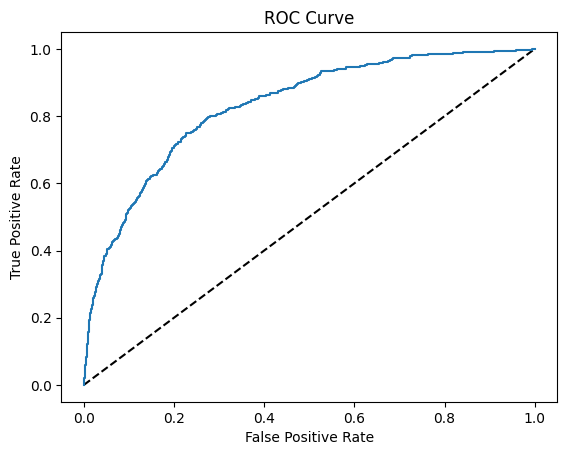

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)